# Time Series Analysis of Daily Air Quality Index (AQI)

---


## Abstract

This project explores daily PM2.5 (particulate matter with a diameter of 2.5 micrometers or less) Air Quality Index (AQI) data from 2023 in Algeria to identify patterns and forecast future pollution levels. After cleaning and transforming the data, candidate time series models are specified and evaluated using standard diagnostics. A final model will be chosen for short-term forecasting, with the goal of informing public health recommendations and guiding air pollution management strategies.

---


## Introduction

Air pollution is a pressing issue in many urban areas. PM2.5 is often cited as a primary culprit due to its ability to penetrate deep into the respiratory system, contributing to various health problems. The primary goal of this project is to analyze daily PM2.5 Air Quality Index (AQI) readings for a single year (2023) in Algeria and develop forecasts that can inform public health guidelines and environmental policies.


### About the Data

- **Source:** [AQICN platform](https://aqicn.org/data-platform/register/)  
- **Form:** CSV file containing daily AQI measurements  
- **Description:** Focused on PM2.5 levels, which are reported as AQI values  
- **Timeframe:** Approximately 342 days in 2023 (some missing dates)  
- **Columns:**
  - *Date* – Daily timestamps  
  - *PM2.5* – Corresponding AQI values for each date  
- **Size:** 2 columns × ~343 rows  
- **Sampling Frequency:** Daily measurements, allowing for straightforward time series modeling.


This table from the *AQICN* clarifies the Air Quality and Pollution Measurement more:


<img src="aqi_table.png" alt="AQI Table" width="650"/>


## Data Loading and Preprocessing

In this section, we load the necessary libraries, read in the AQI dataset, and perform various preprocessing steps such as date handling, missing data interpolation, and dataset ordering. This ensures our time series is properly formatted and ready for modeling.


In [111]:
# Install required packages 
install.packages(c("tidyverse", "lubridate", "forecast", "tseries", "ggplot2", "dplyr", "zoo","randtests","reshape2"))

# Load libraries 
library(tidyverse)   # Data manipulation and piping
library(lubridate)   # Date handling
library(forecast)    # ARIMA and other time series models
library(tseries)     # Stationarity tests
library(ggplot2)     # Data visualization
library(dplyr)       # Data manipulation 
library(zoo)         # Time series operations (for interpolation)
library(randtests)   # runs test


Warning message:
"packages 'tidyverse', 'lubridate', 'forecast', 'tseries', 'ggplot2', 'dplyr', 'zoo', 'randtests', 'reshape2' are in use and will not be installed"


### Handling Missing Dates 

In this phase, we first load the dataset and handle missing dates by generating a complete sequence of dates and merging it with our original data. Missing PM2.5 values are then filled using linear interpolation. 


In [114]:
# Load the dataset 
data <- read.csv("algiers-us embassy-air-quality.csv", header = TRUE, stringsAsFactors = FALSE)

# Ensure Date column exists 
if (!"Date" %in% names(data)) {
  if ("date" %in% names(data)) {
    names(data)[names(data) == "date"] <- "Date"
  } else {
    stop("Error: 'Date' column not found!")
  }
}

# Convert Date column to Date object 
data$Date <- ymd(data$Date)  

# Create a complete date sequence 
full_dates <- data.frame(Date = seq.Date(from = as.Date("2023-01-01"),
                                           to = as.Date("2023-12-31"),
                                           by = "day"))

# Merge the complete dates with the existing data 
data_complete <- left_join(full_dates, data, by = "Date")

# Fill missing PM2.5 values using linear interpolation 
data_complete$pm25 <- na.approx(data_complete$pm25, rule = 2)

# Display the full transformed dataset 
View(data_complete)

sum(is.na(data_complete$pm25)) # ensure no missing values


Date,pm25
<date>,<dbl>
2023-01-01,62
2023-01-02,62
2023-01-03,63
2023-01-04,59
2023-01-05,51
2023-01-06,59
2023-01-07,59
2023-01-08,56
2023-01-09,51


[1] 0

### Order Dataset by Date
We define a helper function to ensure our dataset is sorted chronologically, this step will be crucial in time series analysis.


In [ ]:
order_dataset_by_date <- function(df) {
  # Convert Date column to Date format
  df$Date <- as.Date(df$Date, format = "%d-%m-%Y")
  
  # Sort dataset by Date in ascending order
  df <- df[order(df$Date), ]
  
  return(df)
}

# Apply the function to the dataset
data_complete <- order_dataset_by_date(data_complete)

# View the sorted dataset
View(data_complete)


,Date,pm25
,<date>,<dbl>
1,2023-01-01,62
2,2023-01-02,62
3,2023-01-03,63
4,2023-01-04,59
5,2023-01-05,51
6,2023-01-06,59
7,2023-01-07,59
8,2023-01-08,56
9,2023-01-09,51


### Convert to Time Series Object
Finally, we convert the PM2.5 values into a time series object with a daily frequency, preparing it for further analysis and modeling.


In [116]:
pm25_ts <- ts(data_complete$pm25, frequency = 365)

# Check the structure of the time series
print(pm25_ts)
summary(pm25_ts)

Time Series:
Start = c(1, 1) 
End = c(1, 365) 
Frequency = 365 
  [1]  62.00000  62.00000  63.00000  59.00000  51.00000  59.00000  59.00000
  [8]  56.00000  51.00000  52.00000  54.00000  53.00000  54.00000  57.00000
 [15]  53.00000  52.00000  52.00000  51.00000  49.00000  53.00000  51.00000
 [22]  55.00000  58.00000  52.00000  50.00000  52.00000  49.00000  53.00000
 [29]  47.00000  54.00000  57.00000  59.00000  54.00000  56.00000  56.00000
 [36]  57.00000  52.00000  58.00000  57.00000  49.00000  50.00000  51.00000
 [43]  59.00000  57.00000  58.00000  56.00000  57.00000  59.00000  61.00000
 [50]  64.00000  65.00000  66.00000  70.00000  77.00000  71.00000  49.00000
 [57]  44.00000  52.00000  52.00000  50.00000  53.00000  49.00000  52.00000
 [64]  58.00000  54.00000  49.00000  49.00000  54.00000  52.00000  52.00000
 [71]  53.00000  60.00000  53.00000  48.00000  53.00000  58.00000  55.00000
 [78]  53.00000  52.00000  50.00000  57.00000  58.00000  56.00000  56.00000
 [85]  54.00000  47.0000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   43.00   53.00   54.07   59.00  159.00 

## Exploratory Data Analysis (EDA) 

In this section, we visualize the PM2.5 data and examine its distribution and correlation structure. These plots help us understand the overall behavior of the time series, identify potential trends or seasonal patterns.


**1. Daily PM2.5 AQI Plot**  

- Shows noticeable spikes without a clear long-term trend.  

- No strong seasonal pattern, but certain months have notably higher readings.


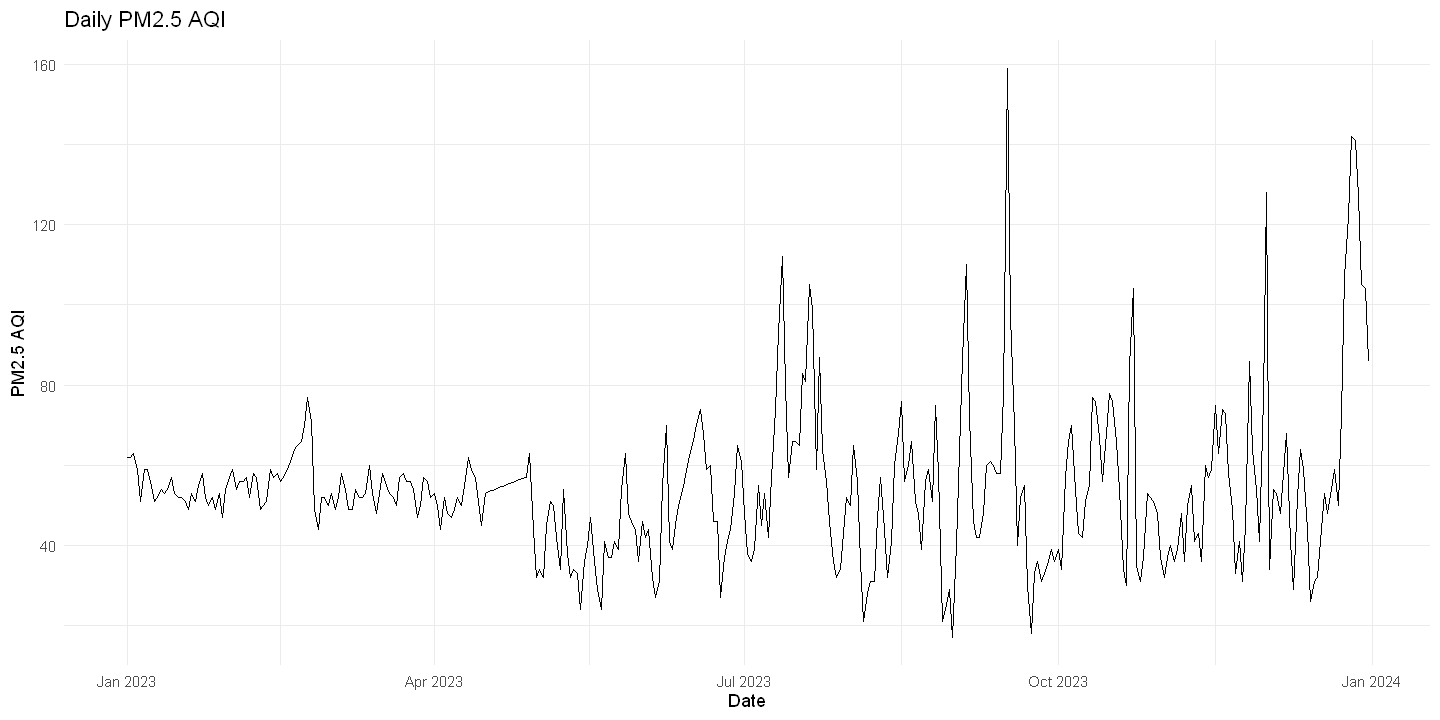

In [117]:
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(data_complete, aes(x = Date, y = pm25)) +
  geom_line(color = "black") +
  labs(
    title = "Daily PM2.5 AQI",
    x = "Date",
    y = "PM2.5 AQI"
  ) +
  theme_minimal()



**2. Histogram**  

- Right-skewed distribution with most values between 30–60.  

- A long tail above 100 indicates potential outliers.


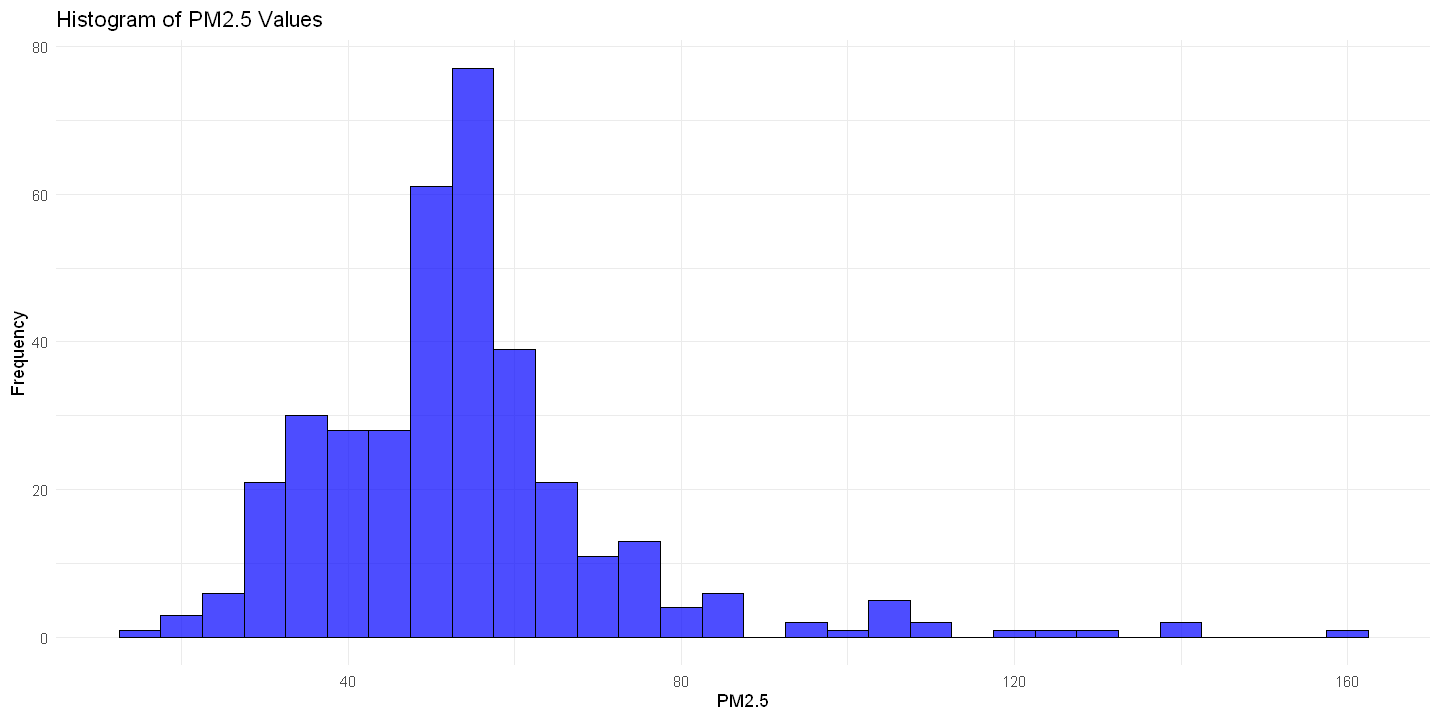

In [118]:
# Histogram of PM2.5 values
ggplot(data_complete, aes(x = pm25)) +
  geom_histogram(binwidth = 5, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of PM2.5 Values", x = "PM2.5", y = "Frequency") +
  theme_minimal()


**3. QQ Plot**  
- Heavy right tail deviates significantly from the normal line.  

- Confirms the distribution is not normal.


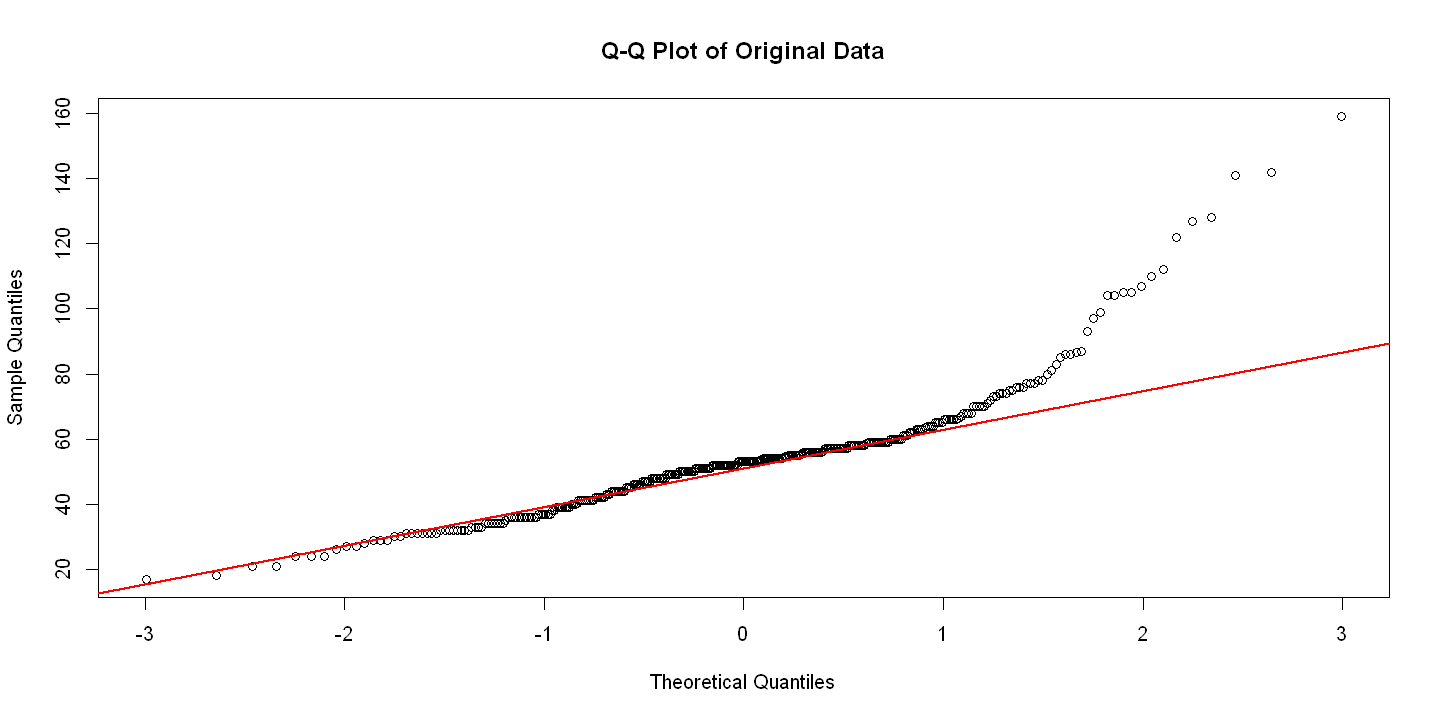

In [ ]:
par(bg = "white") # Make the background white for visibility 

# QQ plot
qqnorm(data_complete$pm25, 
       main = "Q-Q Plot of Original Data",
       col = "black",    # color of the points
       pch = 1)          # point symbol
qqline(data_complete$pm25, col = "red", lwd = 2)


**4. ACF & PACF**  
- ACF shows a strong lag-1 correlation but drops quickly afterward.  

- PACF has a prominent spike at lag 1, suggesting an AR(1)-type model.


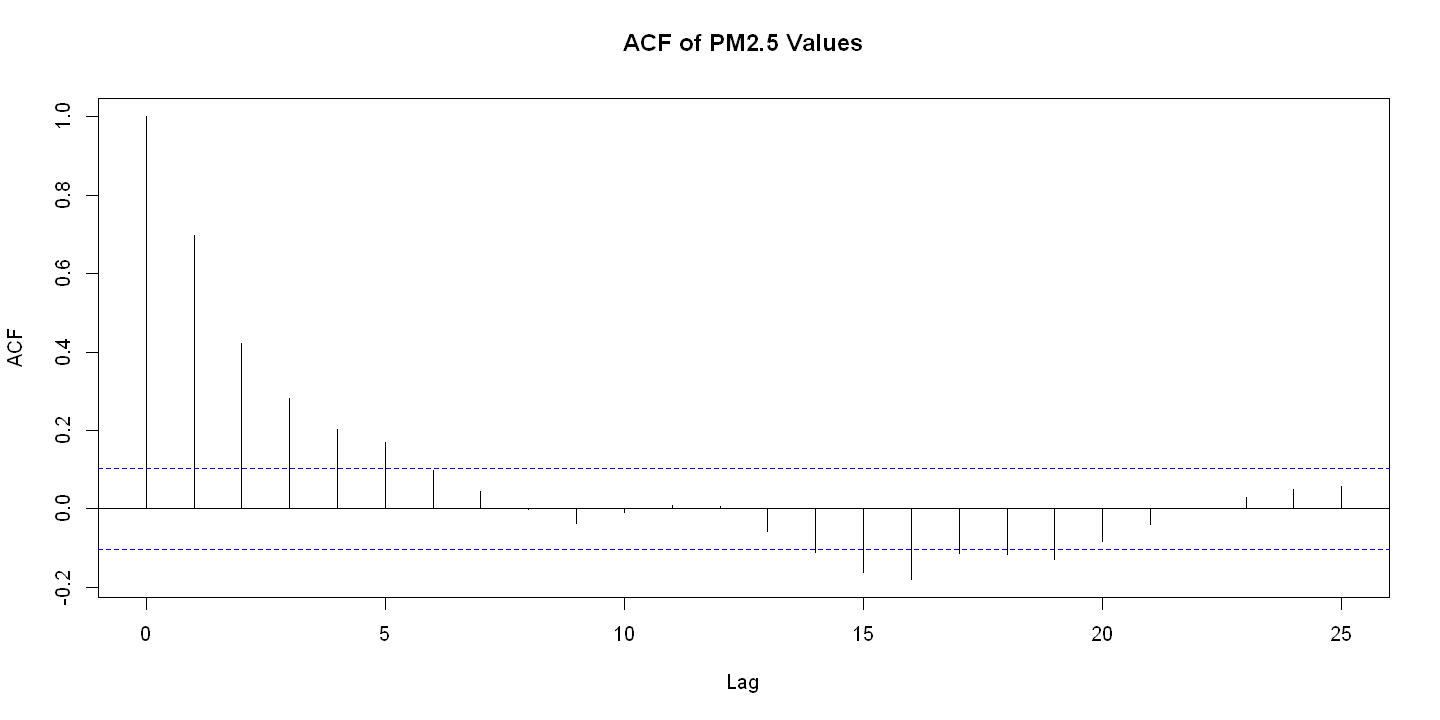

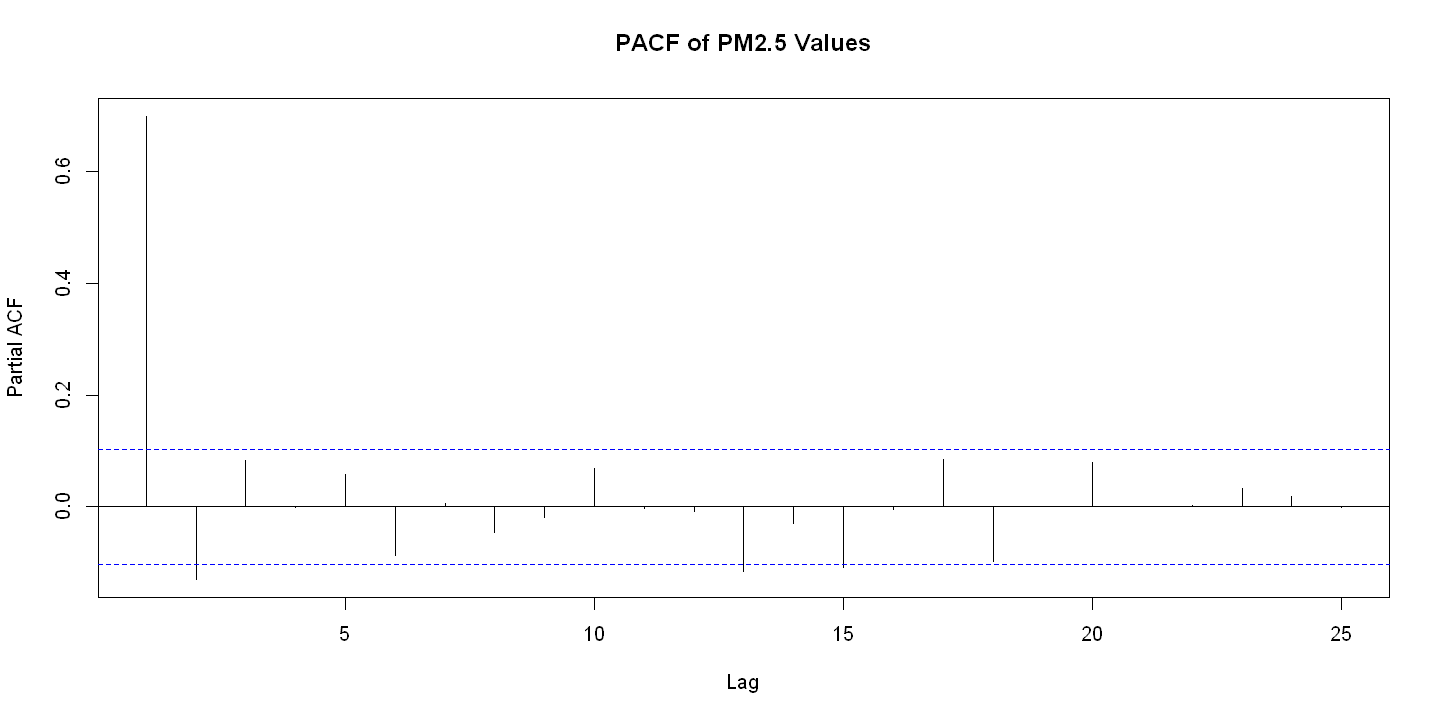

In [122]:
par(bg = "white") # Make the background white for visibility 

#ACF Plot for PM2.5 values
acf(data_complete$pm25, main = "ACF of PM2.5 Values")

# PACF Plot for PM2.5 values
pacf(data_complete$pm25, main = "PACF of PM2.5 Values")

### **Overall**  
- Data is skewed and shows event-driven spikes rather than seasonality.  

- A possible simple ARIMA approach with possible transformation (to handle skewness/outliers) seems appropriate for further modeling.


## Model Specification and Candidate Evaluation

In this phase, we split the dataset into training and testing sets, address outliers, apply variance stabilization, and plot the transformed series. These steps prepare the data for model fitting and help in suggesting candidate models. Evaluating candidate models using AIC and BIC to select and ensure further the candidate models.


### Data Splitting: Train and Test

To effectively train and evaluate our time series models, we split the dataset into two parts:

- **Training Set (80%)**: Used to fit and train the model.

- **Test Set (20%)**: Used to test and evaluate the model performance on unseen data.


In [123]:
n <- nrow(data_complete) # the total number of observations

train_size <- floor(0.8 * n) # the training set size (80% of the dataset)

# Split the data: first 80% for training, remaining 20% for testing
train <- data_complete[1:train_size, ]
test  <- data_complete[(train_size + 1):n, ]

# the dimensions of each split
print(dim(train))
print(dim(test))


[1] 292   2
[1] 73  2


### Outlier Resolution

As seen in previous plots, there are noticeable spikes that could distort our model estimation. We detect outliers in the PM2.5 data using the IQR method and replaces them with the median, followed by verifying the cleaning with Z-scores and a histogram.


Outliers detected by IQR:
 93 112 83 81 105 99 87 21 21 17 86.75 110 159 97 18 

Remaining Outliers after IQR Replacement (Z-Score Method):
  


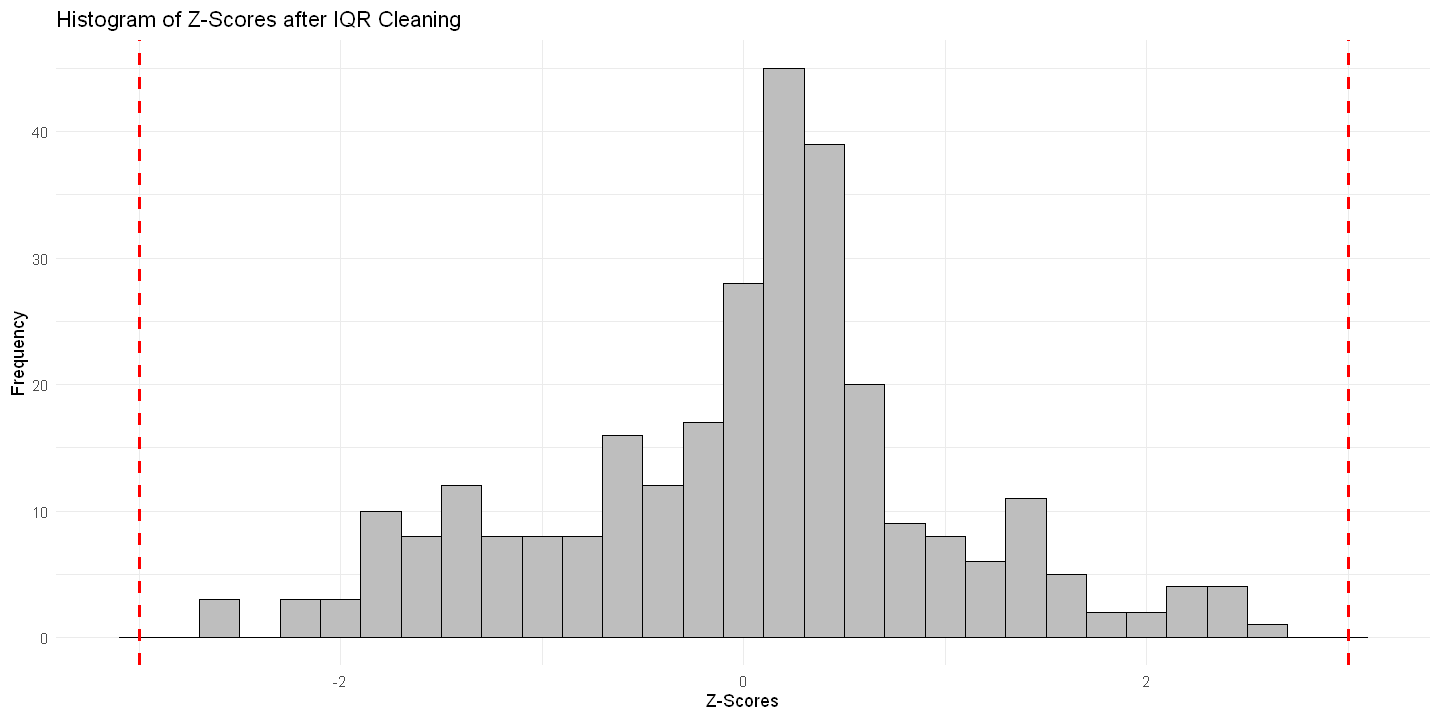

In [124]:
# Store the original PM2.5 values before cleaning
train$pm25_original <- train$pm25  

# Compute IQR and Detect Outliers
Q1 <- quantile(train$pm25, 0.25)
Q3 <- quantile(train$pm25, 0.75)
IQR <- Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR

# Identify outliers
outliers <- train$pm25[train$pm25 < lower_bound | train$pm25 > upper_bound]
cat("Outliers detected by IQR:\n", outliers, "\n")

# Replace Outliers with Median
median_value <- median(train$pm25, na.rm = TRUE)

# Create a cleaned version
train$pm25_cleaned <- train$pm25  
train$pm25_cleaned[train$pm25_cleaned < lower_bound | train$pm25_cleaned > upper_bound] <- median_value

# Compute Z-Scores After Cleaning
train$Z_Score <- scale(train$pm25_cleaned)

# Identify any remaining outliers based on Z-score threshold
z_outliers <- train$pm25_cleaned[abs(train$Z_Score) > 3]
cat("\nRemaining Outliers after IQR Replacement (Z-Score Method):\n", z_outliers, "\n")

# Plot the cleaned data using a histogram
library(ggplot2)
ggplot(train, aes(x = Z_Score)) +
  geom_histogram(binwidth = 0.2, fill="gray", color="black") +
  geom_vline(xintercept = c(-3, 3), color="red", linetype="dashed", size=1) +
  ggtitle("Histogram of Z-Scores after IQR Cleaning") +
  xlab("Z-Scores") +
  ylab("Frequency") +
  theme_minimal()


After handling outliers , the PM2.5 series shows fewer extreme spikes, resulting in a smoother profile.

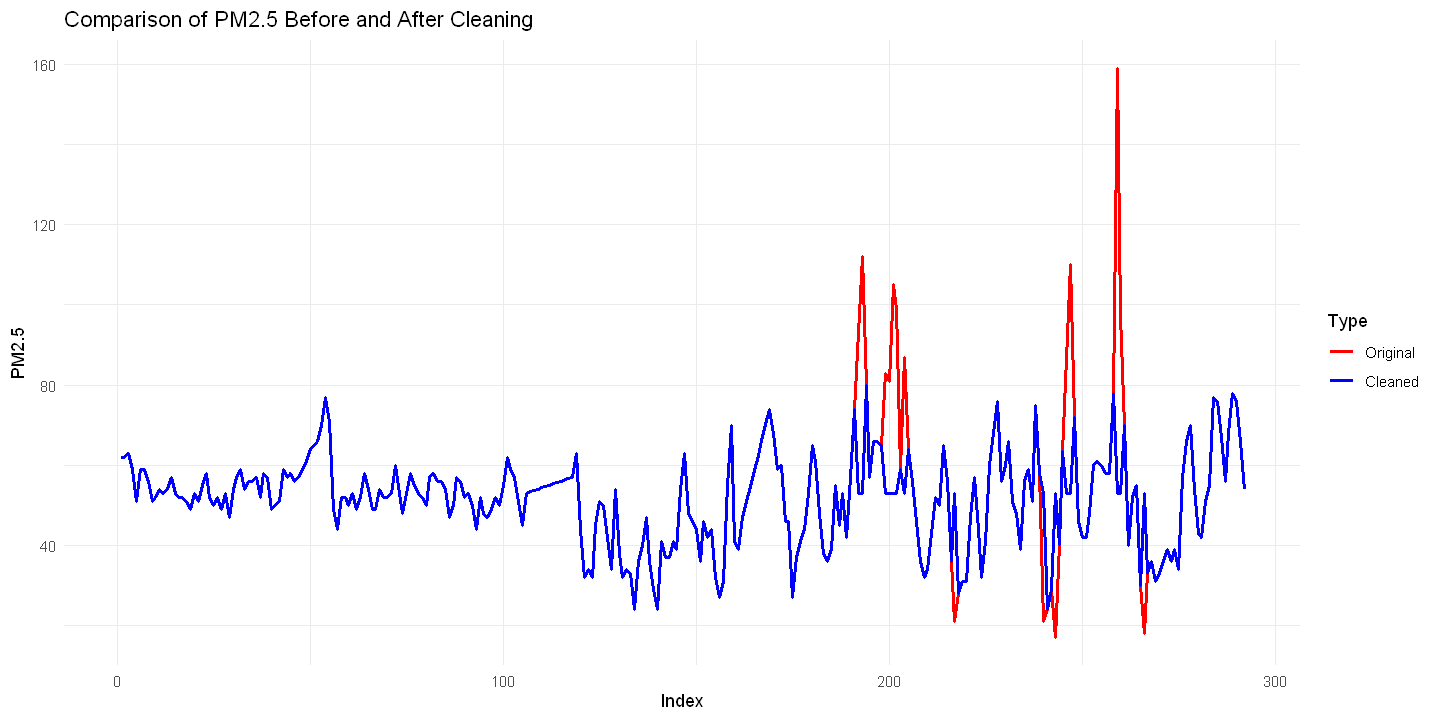

In [125]:
# Create a data frame for plotting
plot_data <- data.frame(
  Index = 1:nrow(train),
  PM25_Original = train$pm25_original,
  PM25_Cleaned = train$pm25_cleaned
)

plot_data_long <- melt(plot_data, id.vars = "Index", variable.name = "Type", value.name = "PM2.5")

# Plot original vs. cleaned PM2.5 values
ggplot(plot_data_long, aes(x = Index, y = PM2.5, color = Type)) +
  geom_line(size = 1) +
  ggtitle("Comparison of PM2.5 Before and After Cleaning") +
  xlab("Index") +
  ylab("PM2.5") +
  theme_minimal() +
  scale_color_manual(values = c("red", "blue"), labels = c("Original", "Cleaned"))


### Variance Stability

To ensure that our time series models meet the assumption of homoscedasticity (constant variance over time), we first examine whether the variance is stable. If the variance increases or decreases significantly with the level of the series, a variance-stabilizing transformation (such as Box-Cox) can help. 

We start by confirming that the cleaned PM2.5 data has no zero or negative values. Then, we estimate the optimal Box-Cox lambda and apply the transformation.


In [126]:
# Make sure there are no zero or negative values
summary(train$pm25_cleaned)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24.00   45.75   53.00   51.62   57.00   80.00 

Optimal lambda for Box-Cox on cleaned data: 0.3504523 


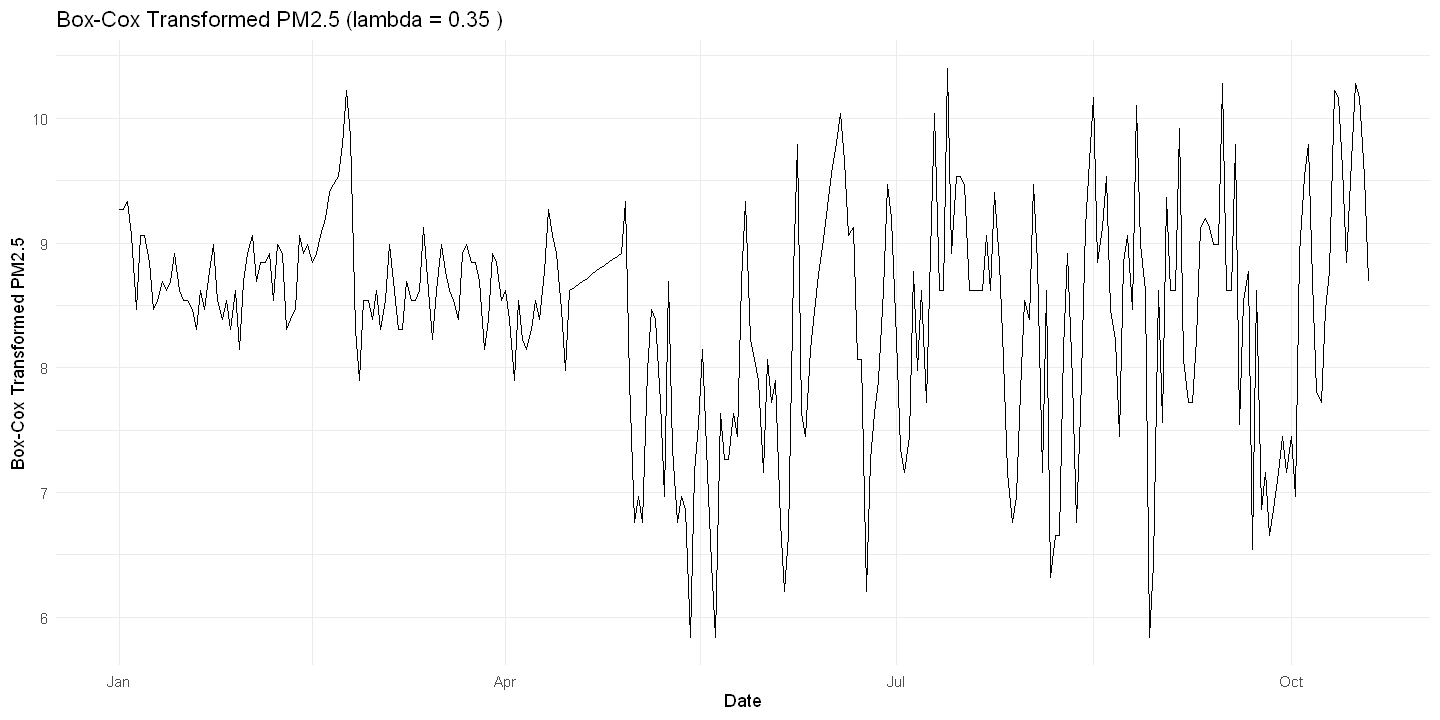

In [127]:
# Estimate the optimal lambda for the cleaned PM2.5 data
lambda_clean <- BoxCox.lambda(train$pm25_cleaned)
cat("Optimal lambda for Box-Cox on cleaned data:", lambda_clean, "\n")

# Apply the Box-Cox transformation on the cleaned data
train$pm25_boxcox <- BoxCox(train$pm25_cleaned, lambda_clean)

# Ensure the Date column is in Date format
train$Date <- as.Date(train$Date)

# Plot only the Box-Cox transformed data
ggplot(train, aes(x = Date, y = pm25_boxcox)) +
  geom_line(color = "black", na.rm = TRUE) +
  labs(
    title = paste("Box-Cox Transformed PM2.5 (lambda =", round(lambda_clean, 3), ")"),
    x = "Date",
    y = "Box-Cox Transformed PM2.5"
  ) +
  theme_minimal()


#### **Interpretation of Box-Cox Transformation**

We found that the optimal lambda for the cleaned PM2.5 data is approximately **0.35**. This compresses larger PM2.5 values more than smaller ones, helping stabilize variance by reducing the impact of extreme spikes.

Visually, the variance appears more stable than before, though some moderate fluctuations remain. keeping in mind that minor variance instability may still be present, since this is not for strict inference or precise confidence intervals but for basic forecasting purposes, the current transformation should be sufficient.


We can now proceed to stationarity checks, autocorrelation analysis, and ultimately fit a time-series model on this Box-Cox-transformed data.

### Stationarity with the Augmented Dickey-Fuller (ADF) Test

To verify that our Box-Cox-transformed series is stationary, we apply the Augmented Dickey-Fuller (ADF) test. 

In [128]:
# This will tell us how many differences are suggested for stationarity
diffs_required <- ndiffs(train$pm25_boxcox, test = "adf")
cat("Number of differences recommended:", diffs_required, "\n")

# ADF test
adf.test(train$pm25_boxcox)


Number of differences recommended: 0 


Warning message in adf.test(train$pm25_boxcox):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train$pm25_boxcox
Dickey-Fuller = -4.5167, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


#### **Interpretation of ADF Results**

- **Test Statistic**: it is sufficiently negative -4.5, it indicates a stronger likelihood of stationarity.

- **p-value**: A small p-value 0.01 allows us to reject the null hypothesis of non-stationarity.

With a sufficiently negative test statistic and a small p-value, we conclude that the series is likely stationary hence this implies that no further differencing is required for our time-series model.


### Further Diagnostic Plots

To gain deeper insight into the distribution and autocorrelation structure of our Box-Cox-transformed data, we create several plots:


### 1. Histogram and QQ Plot

1. **Histogram** – Shows reduced skewness and a more balanced spread after the Box-Cox transformation, the observations cluster around the center, indicating a possible improvement in normality compared to the original data. 

2. **QQ Plot** – The points lie reasonably close to the diagonal line, suggesting that the transformed data is approximately normally distributed. Some minor deviations can be seen in the extreme tails, but overall, the fit looks good.

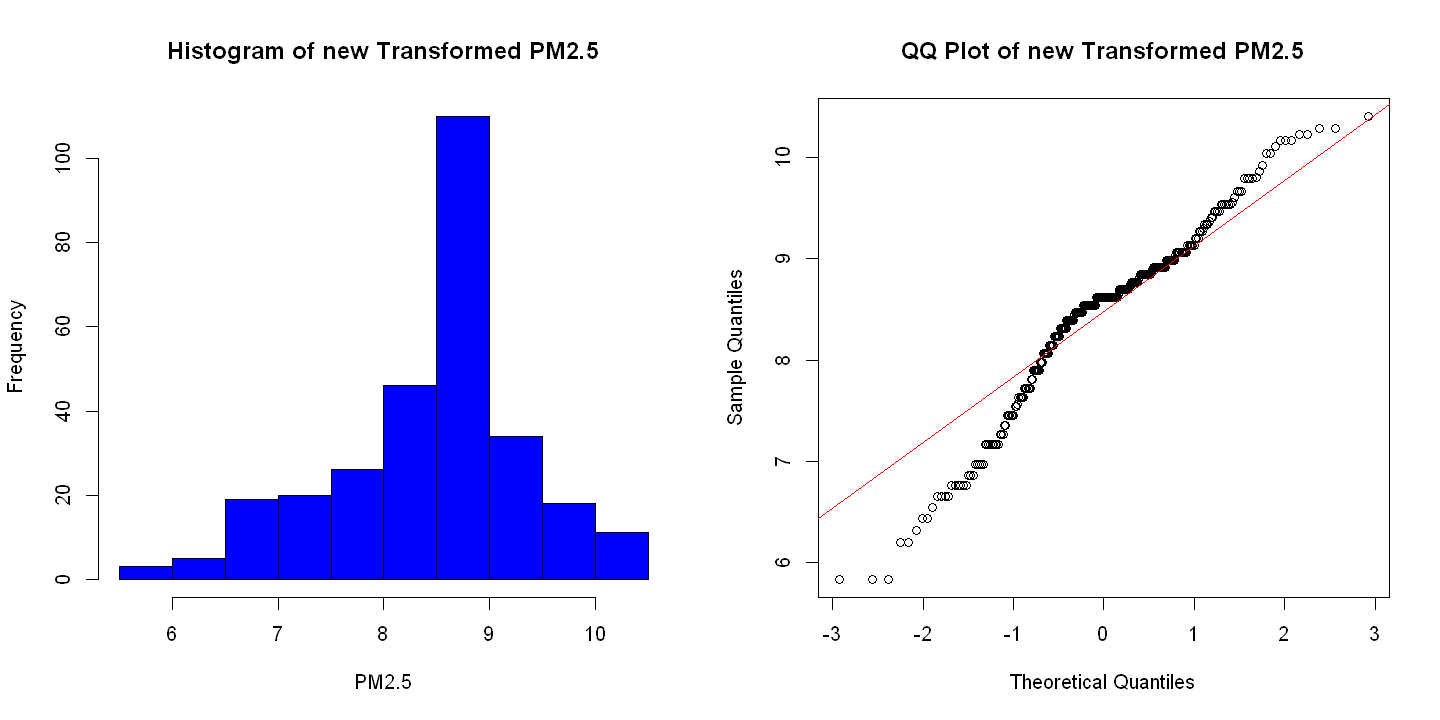

In [27]:
par(bg="white")
par(mfrow = c(1, 2))  # side-by-side

# 1. Histogram
hist(train$pm25_boxcox,
     main = "Histogram of new Transformed PM2.5",
     xlab = "PM2.5",
     col = "blue",
     border = "black")

# 2. QQ Plot
qqnorm(train$pm25_boxcox,
       main = "QQ Plot of new Transformed PM2.5")
qqline(train$pm25_boxcox, col = "red")
par(mfrow = c(1, 1)) 



### 2. ACF and PACF

   - The **ACF** plot Indicates significant autocorrelation at lower lags but a faster decay compared to the original series. This maybe a low-order MA or ARMA component.
   
   - The **PACF** shows a few spikes at the first lags but then quickly settles near zero, suggesting a potential AR(1) or AR(2) structure may capture most of the dependence.
   
   - Because the **ADF test** indicated no need for differencing (d = 0), a likely starting point could be **ARIMA(p, 0, q)** with small p and q.
   Thus we suggest :

**Possible Candidate Models:**

- **ARIMA(1,0,0):** Suggested by the strong lag-1 partial autocorrelation and relatively quick ACF decay.  

- **ARIMA(2,0,0):** There is some autocorrelation at lag 2, a second AR term may improve the fit.  

- **ARIMA(1,0,1):** The ACF indicates a short-term MA component, combining AR(1) and MA(1) can capture both immediate and short-lag dependencies. 

- **ARIMA(1,0,2):** The presence of a stronger second-order MA effect in the ACF suggests that an MA(2) component might better account for short-term fluctuations.  

- **ARIMA(2,0,1):** A combination of two AR terms and one MA term could balance both short and slightly longer-term dependencies, as indicated by the PACF and ACF patterns.  


In next steps, fitting each of these models and comparing AIC/BIC will help determine the best choice.


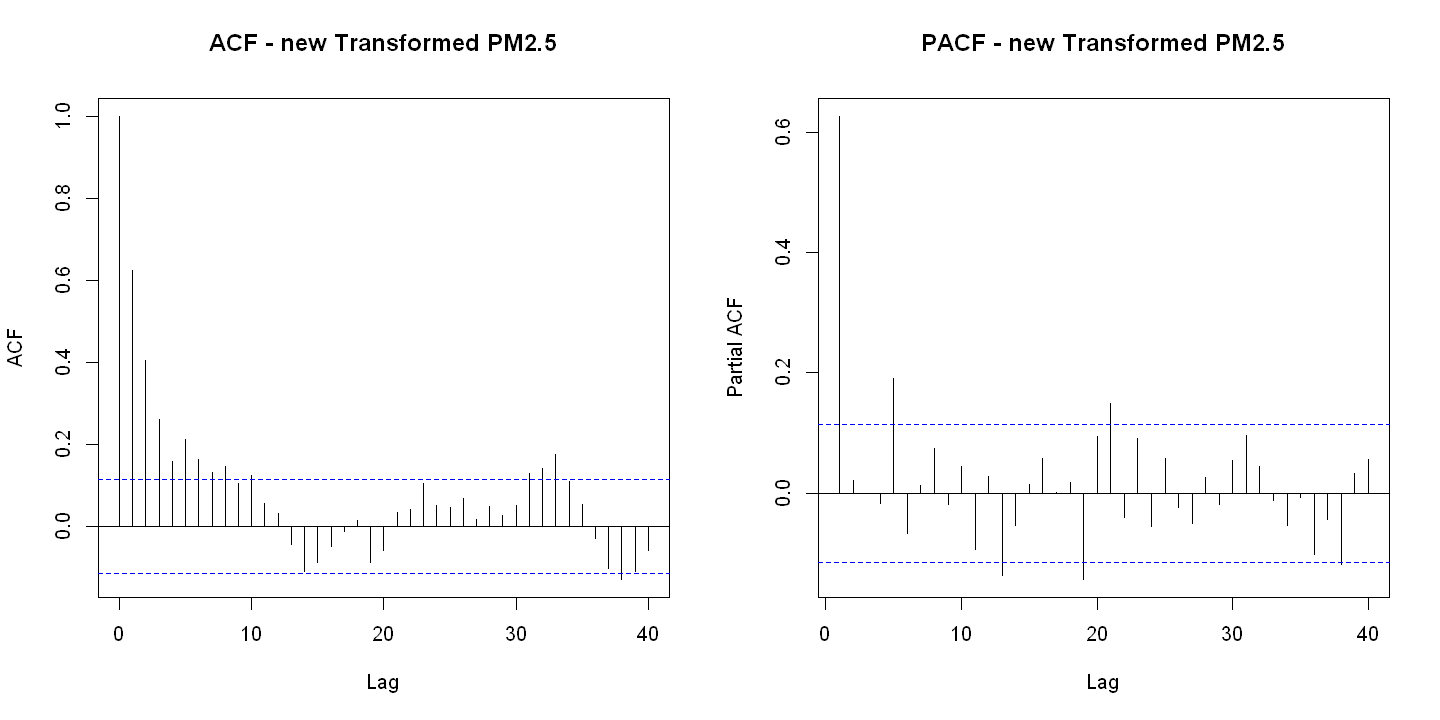

In [28]:
par(bg="white")
par(mfrow = c(1, 2))  # side-by-side
acf(train$pm25_boxcox, main = "ACF - new Transformed PM2.5" ,lag.max = 40)
pacf(train$pm25_boxcox, main = "PACF - new Transformed PM2.5" ,lag.max = 40)
par(mfrow = c(1, 1)) 


### 3. **Seasonality Check**

   - To check for **weekly or monthly cycle** in the daily data, from the ACF at multiples of 7 (weekly) or ~30 (monthly). We see no prominent spikes at those lags or any repeating seasonal pattern. While there are some minor fluctuations, they don’t suggest a strong seasonal component.
   
   
   - Therefore, there is little evidence of monthly or other longer-term seasonality in this data. **non-seasonal ARIMA** model remains a reasonable choice.

### **Normality and Randomness Tests**

In [129]:
shapiro_result <- shapiro.test(train$pm25_boxcox)
shapiro_result



	Shapiro-Wilk normality test

data:  train$pm25_boxcox
W = 0.95974, p-value = 3.143e-07


### 1. Shapiro-Wilk Normality Test

- **Test Statistic (W)**: 0.95974  

- **p-value**: 3.143e-07  

- **Interpretation**: The small p-value (< 0.05) suggests that we reject the null hypothesis of perfect normality. While previous plots (histogram and QQ plot) showed improved normality, the test indicates some remaining departures, especially in the tails.


In [131]:
runs_test_result <- runs.test(train$pm25_boxcox)
runs_test_result



	Runs Test

data:  train$pm25_boxcox
statistic = -8.6258, runs = 63, n1 = 128, n2 = 136, n = 264, p-value <
2.2e-16
alternative hypothesis: nonrandomness


### 2. Runs Test Independence Test

- **Test Statistic (z)**: -8.6258  

- **p-value**: 2.2e-16 

- **Interpretation**: The runs test very small p-value indicates and statistic strongly rejects the hypothesis of randomness, implying that the observations are not independent. This supports the presence of autocorrelation observed in the ACF/PACF plots, confirming that the series has a significant serial dependence.


### **Approach for Selecting Candidate ARIMA Models**

1. **Initial Selection:**  

   - Based on ACF/PACF, choose five candidate models:  
     ARIMA(1,0,0), ARIMA(2,0,0), ARIMA(1,0,2), ARIMA(1,0,1), and ARIMA(2,0,1).

2. **Refinement Using AIC/BIC:**  

   - Compute AIC and BIC for each model and Identify models that perform best on both criteria (those with lowest AIC and BIC), this intersection helps in selecting candidate models that balance *fit* and *parsimony*.

3. **Final Choice:**  

   - Take the models and perform detailed diagnostics before final selection.



In [132]:
# Define the candidate ARIMA orders
candidate_models <- list(
  c(1, 0, 0),
  c(2, 0, 0),
  c(1, 0, 1),
  c(1, 0, 2),
  c(2, 0, 1)

)

# Initialize a data frame to store results
model_results <- data.frame(
  p = integer(),
  d = integer(),
  q = integer(),
  AIC = numeric(),
  BIC = numeric()
)

# Loop through each candidate model
for (model_order in candidate_models) {
  p <- model_order[1]
  d <- model_order[2]
  q <- model_order[3]
  
  # Fit the ARIMA model on the Box-Cox transformed training data
  fit <- arima(train$pm25_boxcox, order = c(p, d, q))
  
  # Extract AIC and BIC
  aic_value <- AIC(fit)
  bic_value <- BIC(fit)
  
  # Append results to the data frame
  model_results <- rbind(
    model_results,
    data.frame(p = p, d = d, q = q, AIC = aic_value, BIC = bic_value)
  )
}

#  order the results by BIC or AIC for convenience
model_results[order(model_results$BIC), ]
model_results[order(model_results$AIC), ]


,p,d,q,AIC,BIC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,619.4521,630.4824
3,1,0,1,621.2811,635.9882
2,2,0,0,621.2823,635.9893
4,1,0,2,623.2793,641.6631
5,2,0,1,623.2824,641.6662


,p,d,q,AIC,BIC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,619.4521,630.4824
3,1,0,1,621.2811,635.9882
2,2,0,0,621.2823,635.9893
4,1,0,2,623.2793,641.6631
5,2,0,1,623.2824,641.6662


- **Top Candidate:**  

ARIMA(1,0,0) (AIC: 619.45, BIC: 630.48) has the lowest AIC and BIC, indicating it strikes the best balance between fit and complexity among the five candidates.

- **other Candidate:**  

ARIMA(2,0,0) and ARIMA(1,0,1) are close contenders but show slightly higher AIC/BIC values.

Overall, either ARIMA(1,0,0) or ARIMA(1,0,1) or ARIMA(2,0,0) is a strong candidate. Final selection will be guided by diagnostic checks and forecast performance .

## Fitting and Diagnostics

In this step, we fit the three most promising ARIMA models—ARIMA(1,0,1), ARIMA(1,0,0), and ARIMA(2,0,0)—to our transformed data. We then perform diagnostic checks (e.g., residual plots, Ljung-Box test) to assess model adequacy and confirm which model best captures the data's structure without leaving significant patterns in the residuals.


### Fitting ARIMA(1,0,1) Model


In [76]:
arima_model_101 <- Arima(train$pm25_boxcox, order = c(1, 0, 1))

# Display a summary of the model
summary(arima_model_101)

Series: train$pm25_boxcox 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1      ma1    mean
      0.6490  -0.0388  8.4568
s.e.  0.0712   0.0939  0.1101

sigma^2 = 0.4824:  log likelihood = -306.64
AIC=621.28   AICc=621.42   BIC=635.99

Training set error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.002497755 0.6909754 0.5153909 -0.7708031 6.370817 0.9479692
                     ACF1
Training set 0.0006038118


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with non-zero mean
Q* = 18.866, df = 8, p-value = 0.01559

Model df: 2.   Total lags used: 10



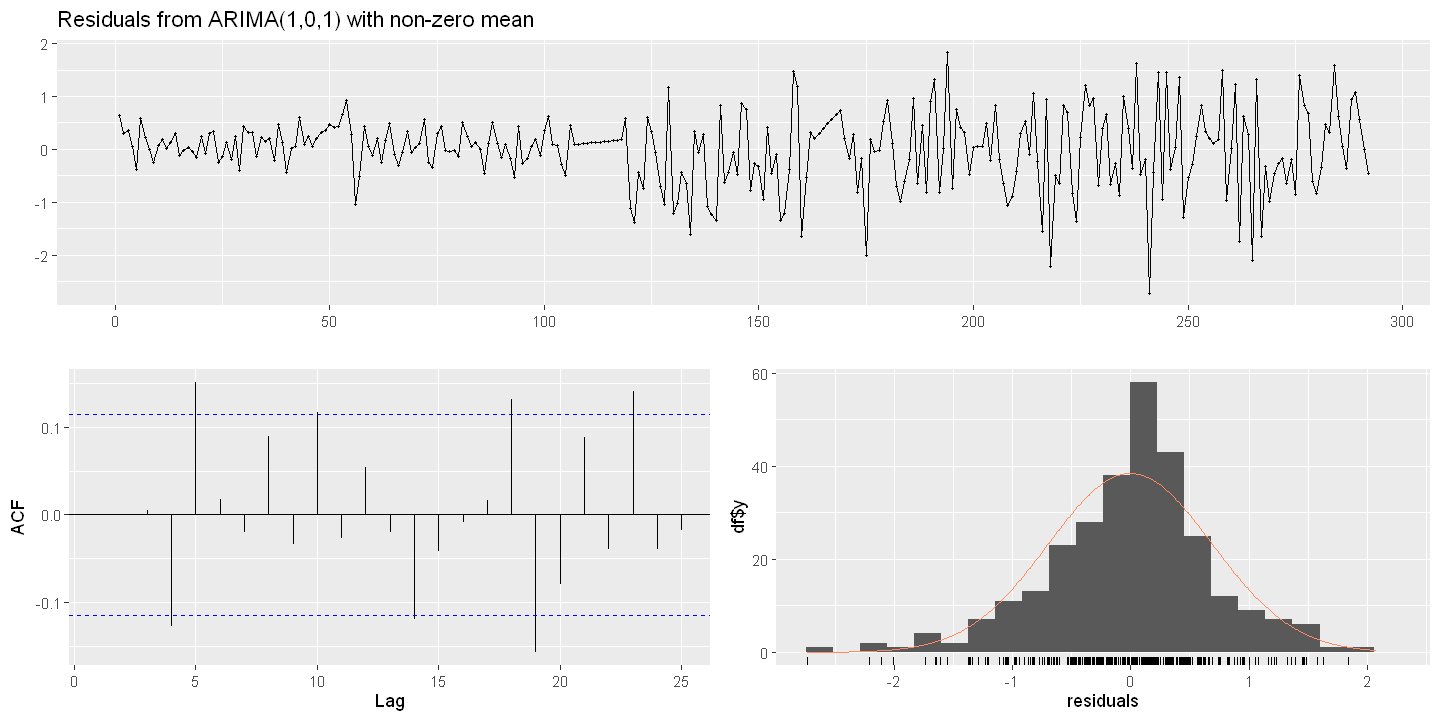

In [77]:
# Diagnostic checks using checkresiduals() from the forecast package
checkresiduals(arima_model_101)

In [78]:
# Extract residuals from the model
residuals_101 <- residuals(arima_model_101)

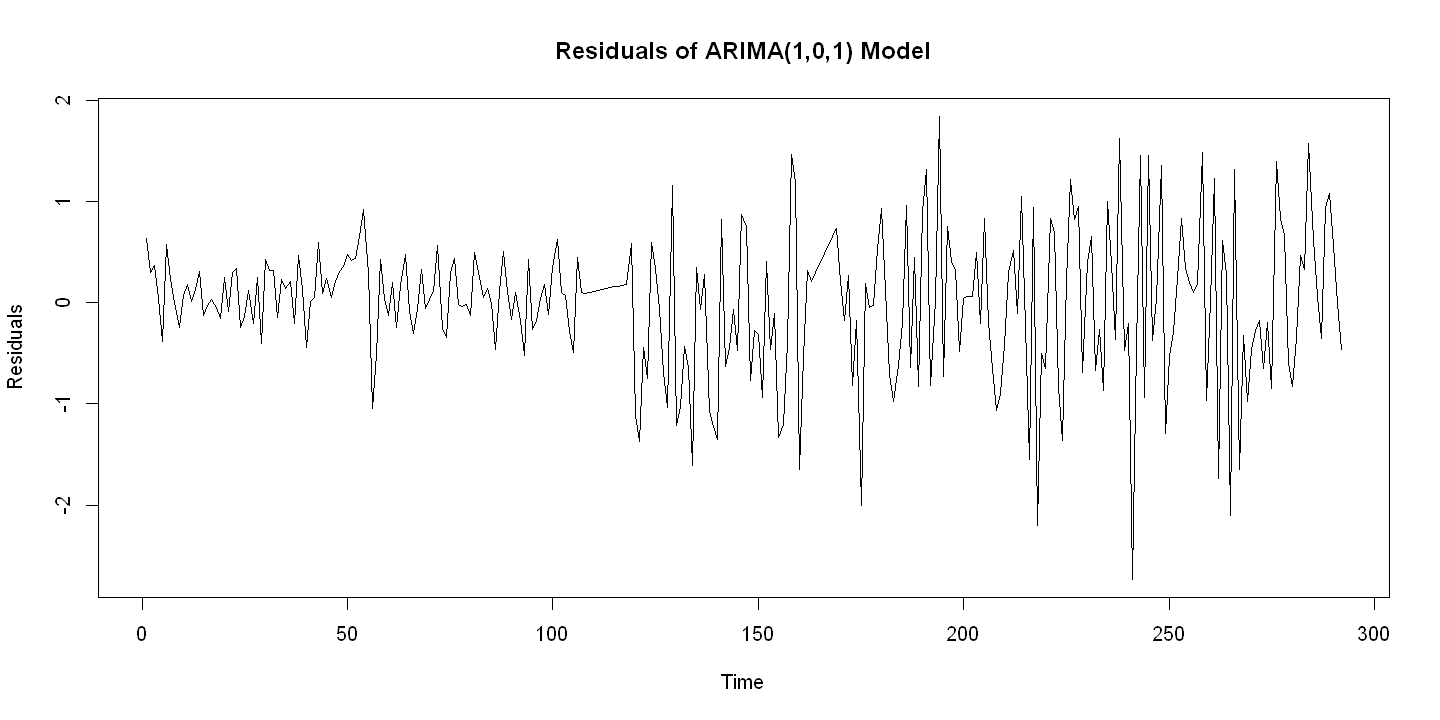

In [79]:
par(bg="white")
# Plot the residuals over time
plot(residuals_101, main = "Residuals of ARIMA(1,0,1) Model", ylab = "Residuals")


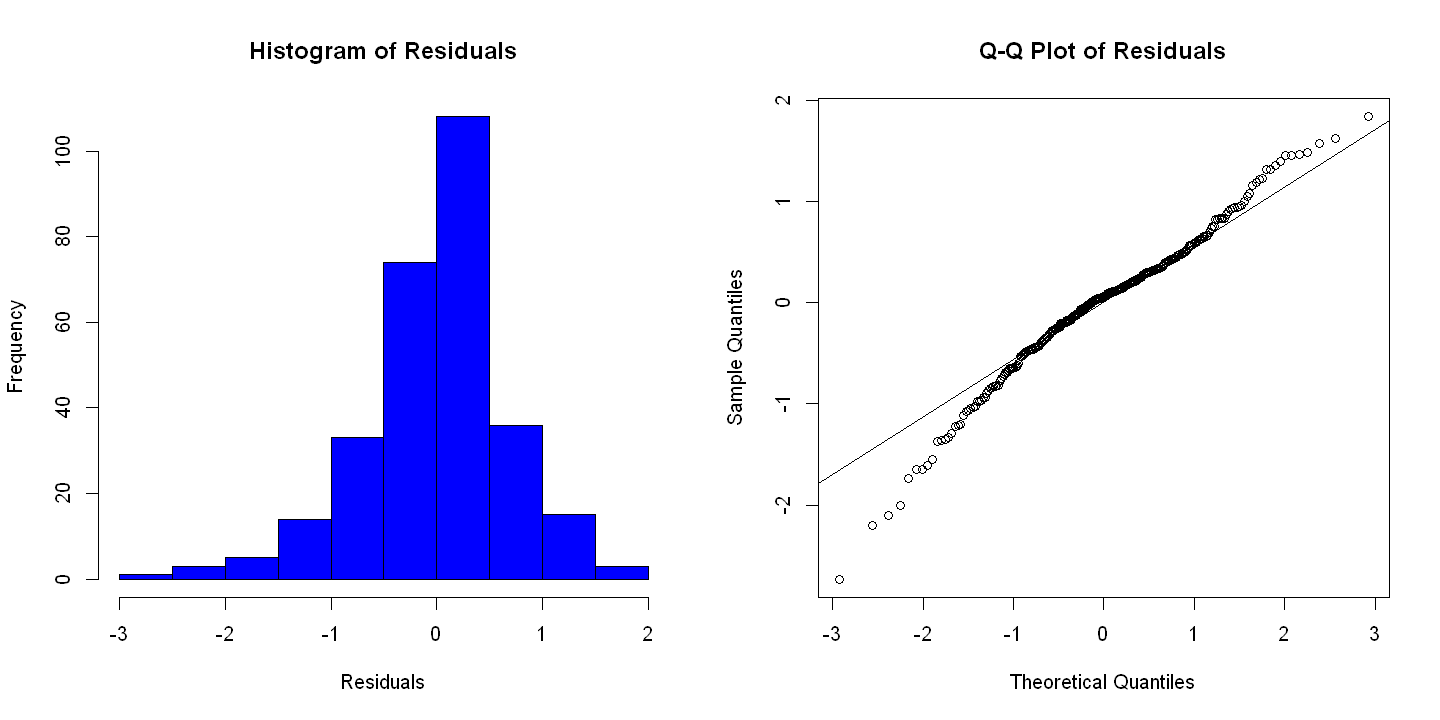

In [80]:
# Set white background and arrange plots side by side
par(bg = "white", mfrow = c(1, 2))

# Histogram of residuals
hist(residuals_101, main = "Histogram of Residuals", xlab = "Residuals", col = "blue")

# Q-Q plot to check for normality
qqnorm(residuals_101, main = "Q-Q Plot of Residuals")
qqline(residuals_101)

# Reset plotting layout
par(mfrow = c(1, 1))


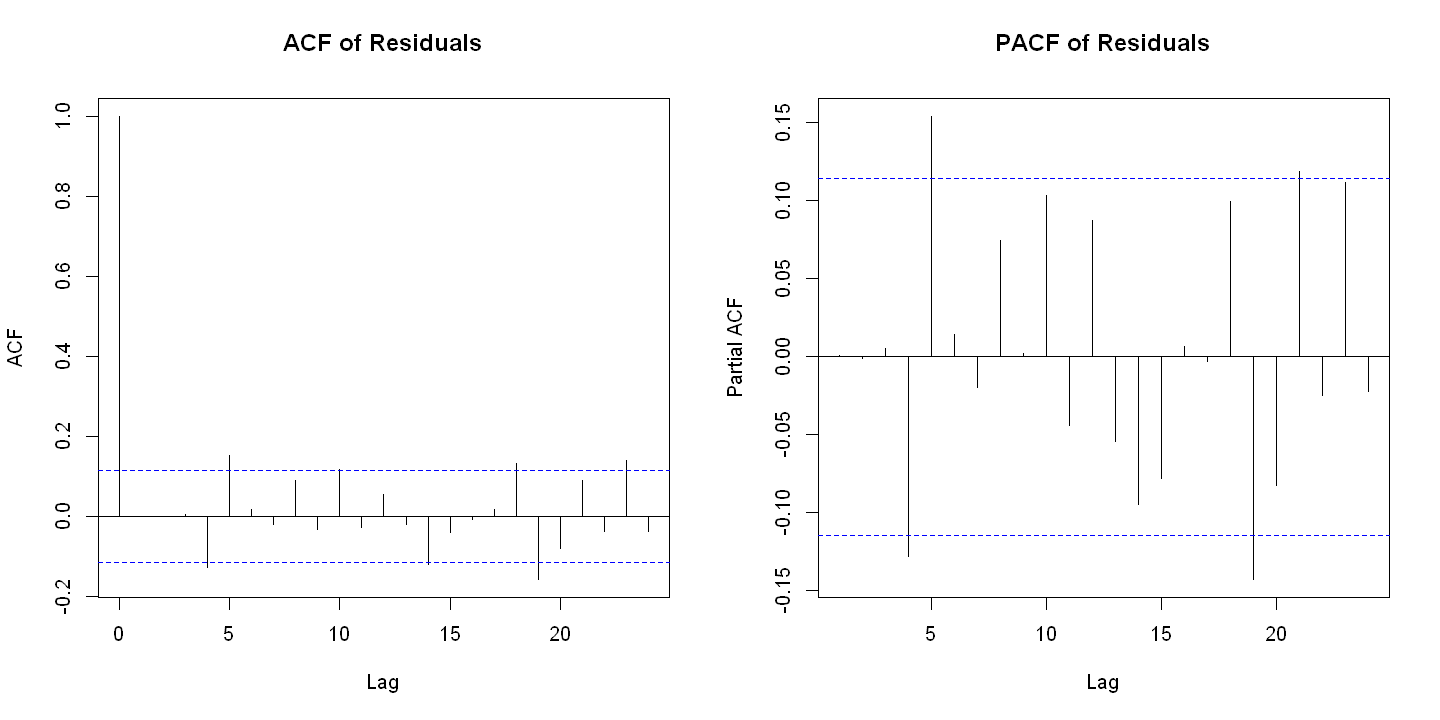

In [81]:
par(bg="white")

# Check for autocorrelation in the residuals
par(mfrow = c(1, 2))
acf(residuals_101, main = "ACF of Residuals")
pacf(residuals_101, main = "PACF of Residuals")
par(mfrow = c(1, 1))


In [82]:
# Shapiro-Wilk test for normality of residuals
shapiro.test(residuals_101)


	Shapiro-Wilk normality test

data:  residuals_101
W = 0.97796, p-value = 0.000179


In [84]:


runs_test_result <- runs.test(residuals_101)
print(runs_test_result)


	Runs Test

data:  residuals_101
statistic = -2.2276, runs = 128, n1 = 146, n2 = 146, n = 292, p-value =
0.02591
alternative hypothesis: nonrandomness



### Model Validation: ARIMA(1,0,1)

**1. Residual Plots (Time Series & Histogram)**

- The residuals fluctuate around zero with no obvious large trends. That suggests the model is capturing a fair amount of structure.
- The histogram of residuals looks roughly bell-shaped, though the **Shapiro–Wilk test** (p = 0.000179) indicates it’s not perfectly normal. 

**2. ACF/PACF of Residuals**

- Most lags appear within the blue confidence bands, it means there’s no major autocorrelation left.

- However, there are lags stands out above the bands. 

**3. Ljung–Box Test**

- The test result is below the 0.05 threshold, suggesting there is some leftover autocorrelation in the residuals.

- Since the p-value is around 0.0156, it’s not extremely low, but still indicates some structure remains.

**4. Runs Test**

- The runs test (p = 0.02591) suggests some degree of non-randomness in the sequence of residuals.

- It’s below 0.05, so it points to some pattern left henec it suggests nonrandomness in the residuals, meaning the model may not fully capture the underlying pattern in the data. 

**Overall Assessment**

Residuals are reasonably centered around zero and Mostly within the confidence bands in the ACF/PACF. The shape of the histogram is not far from normal.

But since The **Ljung–Box** and **Runs tests** show statistically significant leftover structure. The residuals may still contain a slight pattern that ARIMA(1,0,1) is not capturing.

Overall, **ARIMA(1,0,1)** is a **NOT** viable model for forecasting PM2.5 on the transformed data.




### Fitting ARIMA(2,0,0) Model


In [134]:
arima_model_200 <- Arima(train$pm25_boxcox, order = c(2, 0, 0))

# Display a summary of the model
summary(arima_model_200)

Series: train$pm25_boxcox 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1     ar2    mean
      0.6103  0.0242  8.4567
s.e.  0.0584  0.0586  0.1100

sigma^2 = 0.4824:  log likelihood = -306.64
AIC=621.28   AICc=621.42   BIC=635.99

Training set error measures:
                       ME      RMSE      MAE        MPE     MAPE      MASE
Training set -0.002481563 0.6909767 0.515418 -0.7705986 6.371098 0.9480191
                     ACF1
Training set 0.0004993896


	Ljung-Box test

data:  Residuals from ARIMA(2,0,0) with non-zero mean
Q* = 18.862, df = 8, p-value = 0.01562

Model df: 2.   Total lags used: 10



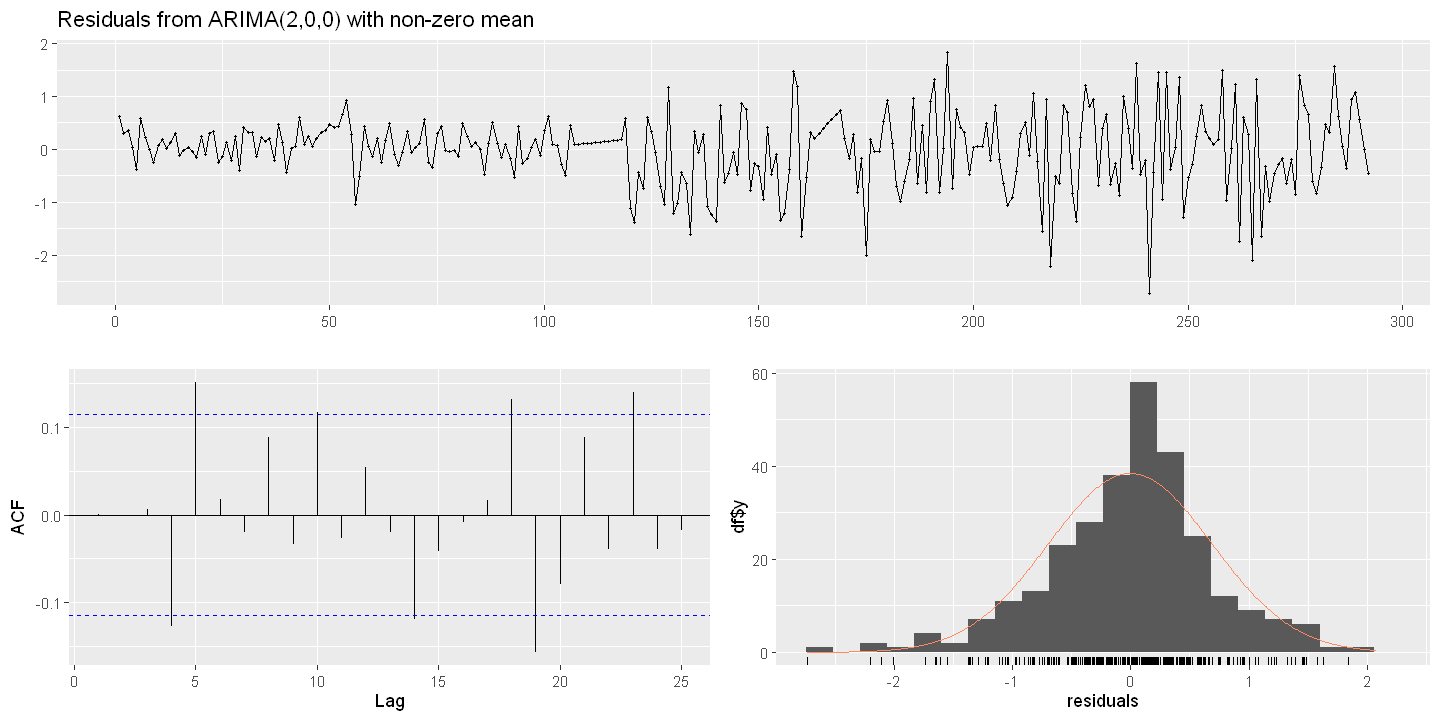

In [135]:
# Diagnostic checks using checkresiduals() from the forecast package
checkresiduals(arima_model_200)


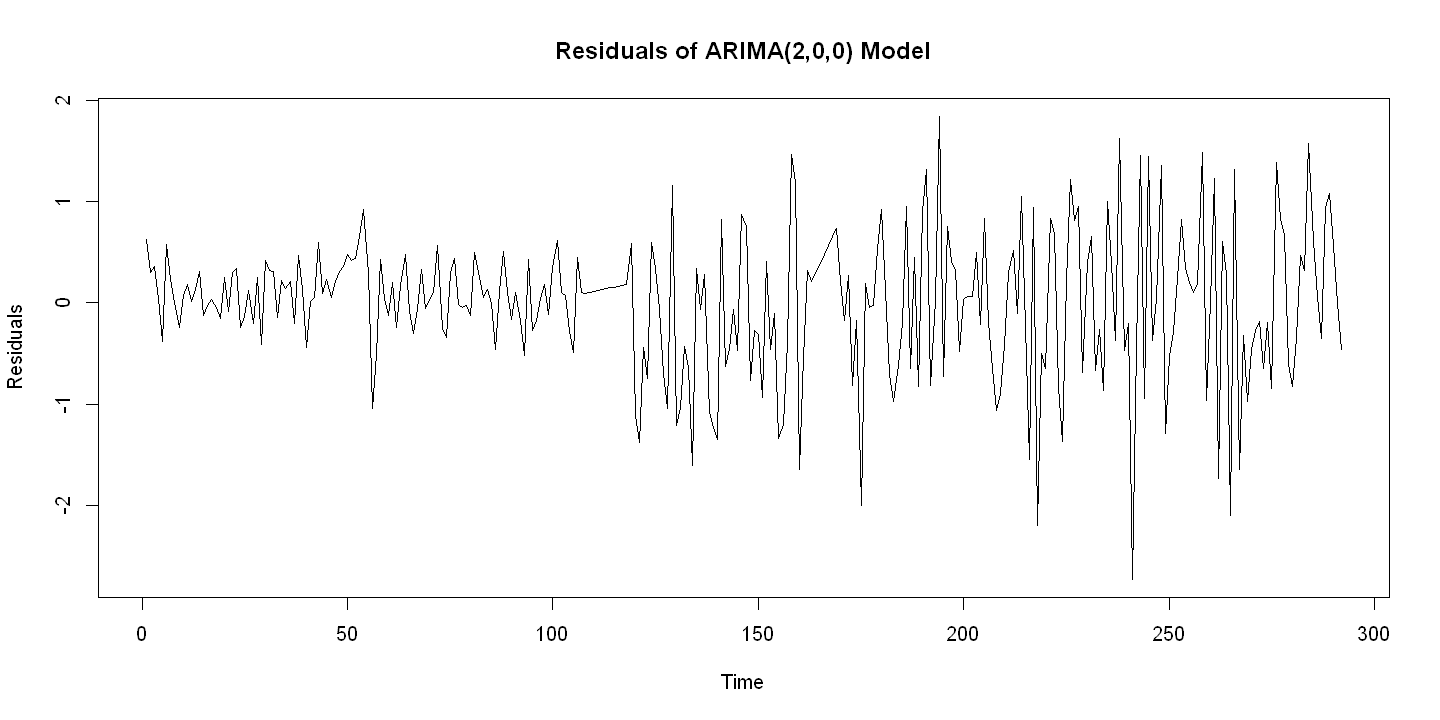

In [138]:
par(bg="white")
# Extract residuals
residuals_200 <- residuals(arima_model_200)

# Plot the residuals over time
plot(residuals_200, main = "Residuals of ARIMA(2,0,0) Model", ylab = "Residuals")


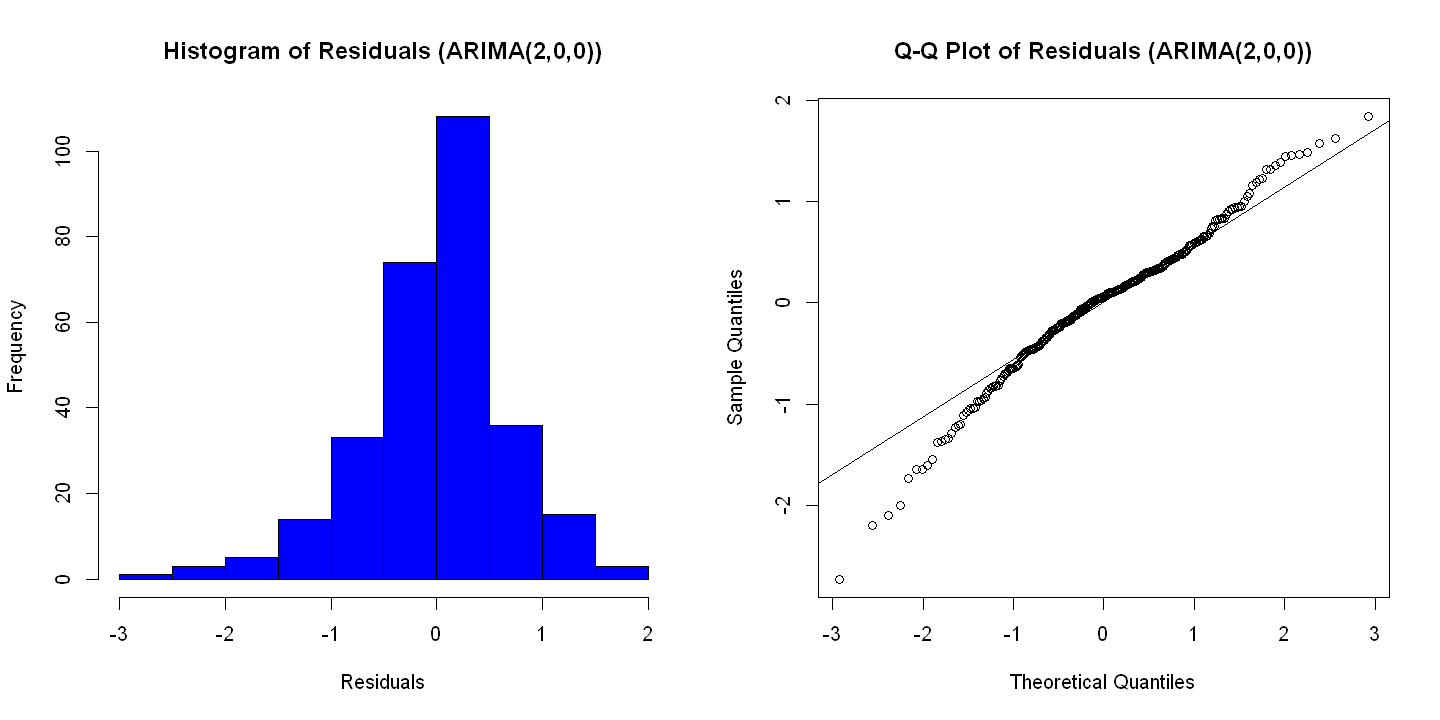

In [137]:
# Plot Histogram and Q-Q plot side by side
par(bg = "white", mfrow = c(1, 2))

# Histogram of residuals
hist(residuals_200, main = "Histogram of Residuals (ARIMA(2,0,0))", xlab = "Residuals", col = "blue")

# Q-Q plot for normality check
qqnorm(residuals_200, main = "Q-Q Plot of Residuals (ARIMA(2,0,0))")
qqline(residuals_200)

# Reset plotting layout
par(mfrow = c(1, 1))

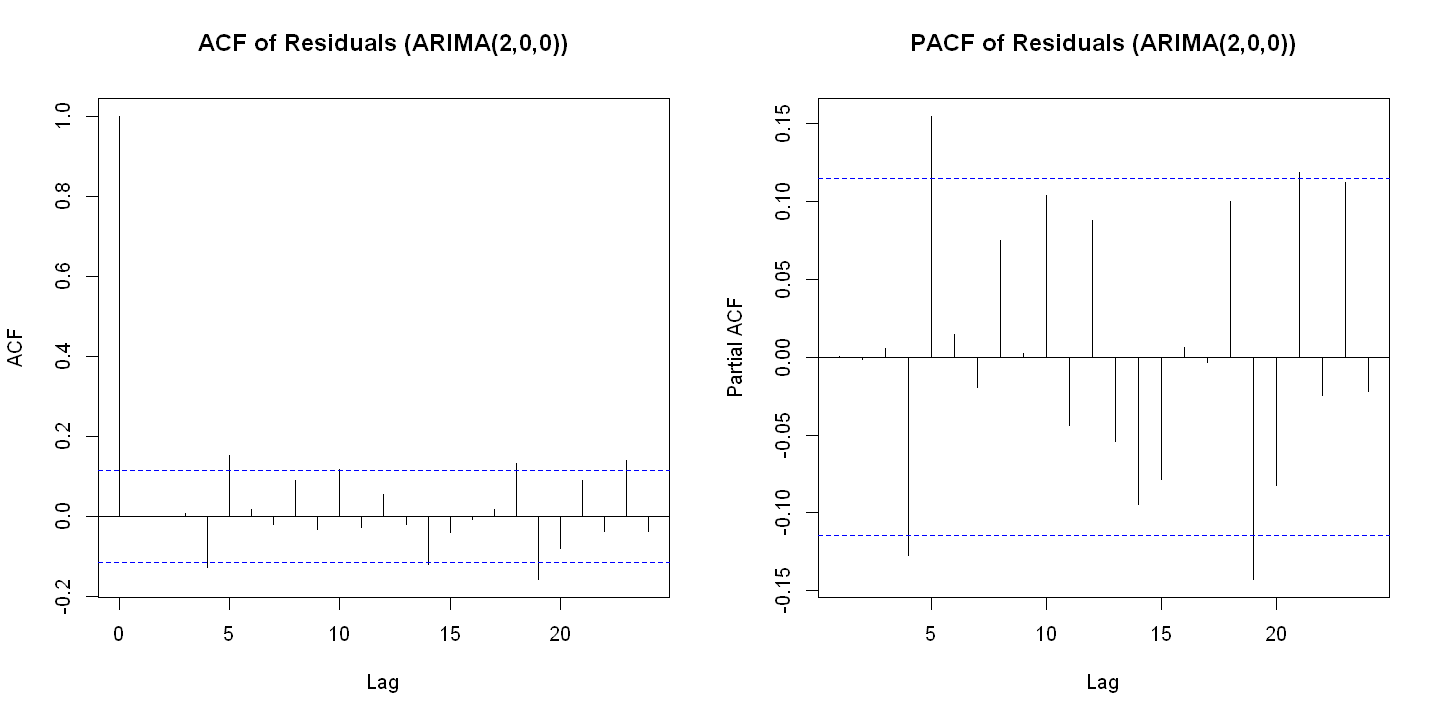

In [139]:
par(bg = "white", mfrow = c(1, 2))

# Check for autocorrelation in residuals
par(mfrow = c(1, 2))
acf(residuals_200, main = "ACF of Residuals (ARIMA(2,0,0))")
pacf(residuals_200, main = "PACF of Residuals (ARIMA(2,0,0))")
par(mfrow = c(1, 1))

In [140]:
# Shapiro-Wilk test for normality
shapiro.test(residuals_200)


	Shapiro-Wilk normality test

data:  residuals_200
W = 0.97798, p-value = 0.00018


In [141]:

runs_test_200 <- runs.test(residuals_200)
print(runs_test_200)


	Runs Test

data:  residuals_200
statistic = -2.1177, runs = 128, n1 = 145, n2 = 145, n = 290, p-value =
0.0342
alternative hypothesis: nonrandomness



### Model Validation: ARIMA(2,0,0)

**1. Residual Plots (Time Series & Histogram)**  

- The time series plot of residuals shows random fluctuations around zero, which is expected in a well-fitted model.  

- The histogram of residuals appears approximately normal but might exhibit slight deviations from normality.  

**2. ACF/PACF of Residuals** 

- The ACF plot of residuals shows that most autocorrelations fall within the confidence limits, indicating no strong serial correlation.  

- However, a few significant spikes suggest the presence of some remaining structure.  

**3. Ljung–Box Test**   

- The low p-value suggests that the residuals are not entirely uncorrelated, implying that some structure remains unexplained by the model.  

**4. Runs Test**   

- A small p-value suggests nonrandomness in the residuals, meaning the model may not fully capture the underlying pattern in the data.  

**Overall Assessment**  

- The residual diagnostics show some signs of model inadequacy since the Ljung-Box test indicates potential autocorrelation and the runs test suggests 
nonrandomness in the residuals and the Shapiro-Wilk test indicates that residuals deviate from normality.  

Overall, the ARIMA(2,0,0) model is **NOT** fully adequate.


### Fitting ARIMA(1,0,0) Model


In [142]:
# Fit ARIMA(1,0,0) model on the Box-Cox–transformed PM2.5 data
arima_model_100 <- Arima(train$pm25_boxcox, order = c(1, 0, 0))

# Display a summary of the model
summary(arima_model_100)


Series: train$pm25_boxcox 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.6254  8.4561
s.e.  0.0455  0.1074

sigma^2 = 0.481:  log likelihood = -306.73
AIC=619.45   AICc=619.54   BIC=630.48

Training set error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.002346906 0.6911791 0.5157875 -0.7694885 6.376266 0.9486987
                    ACF1
Training set -0.01442029


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with non-zero mean
Q* = 19.784, df = 9, p-value = 0.01929

Model df: 1.   Total lags used: 10



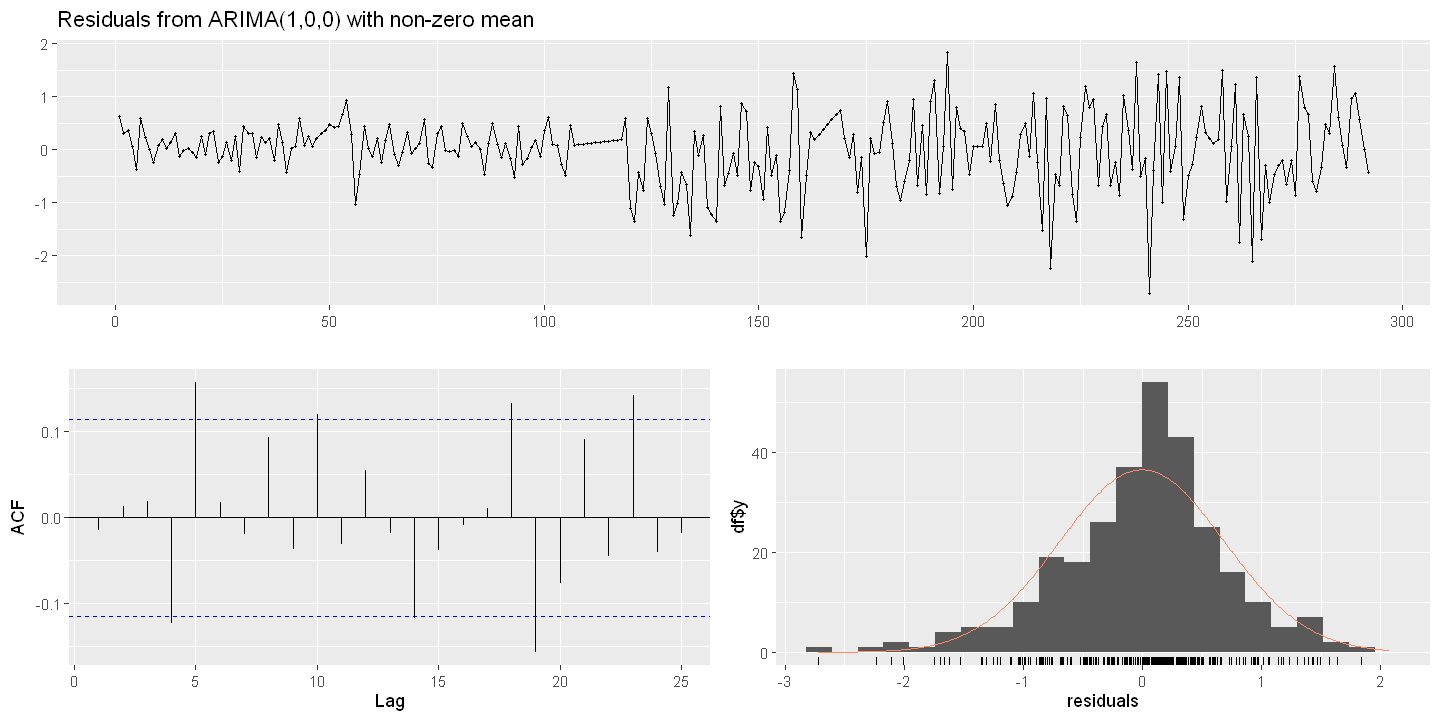

In [143]:
# Diagnostic checks using checkresiduals() from the forecast package
checkresiduals(arima_model_100)


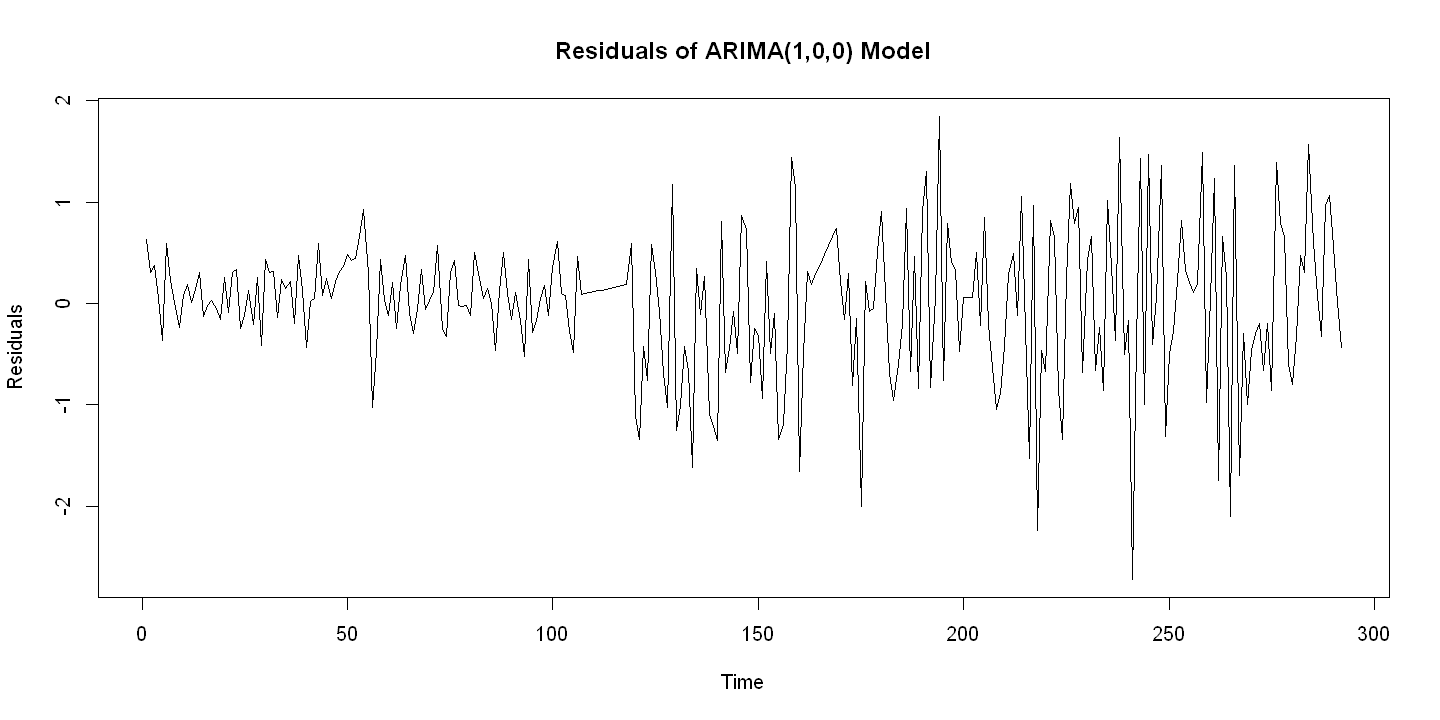

In [144]:
par(bg="white")

# Extract residuals
residuals_100 <- residuals(arima_model_100)

# Plot the residuals over time
plot(residuals_100, main = "Residuals of ARIMA(1,0,0) Model", ylab = "Residuals")


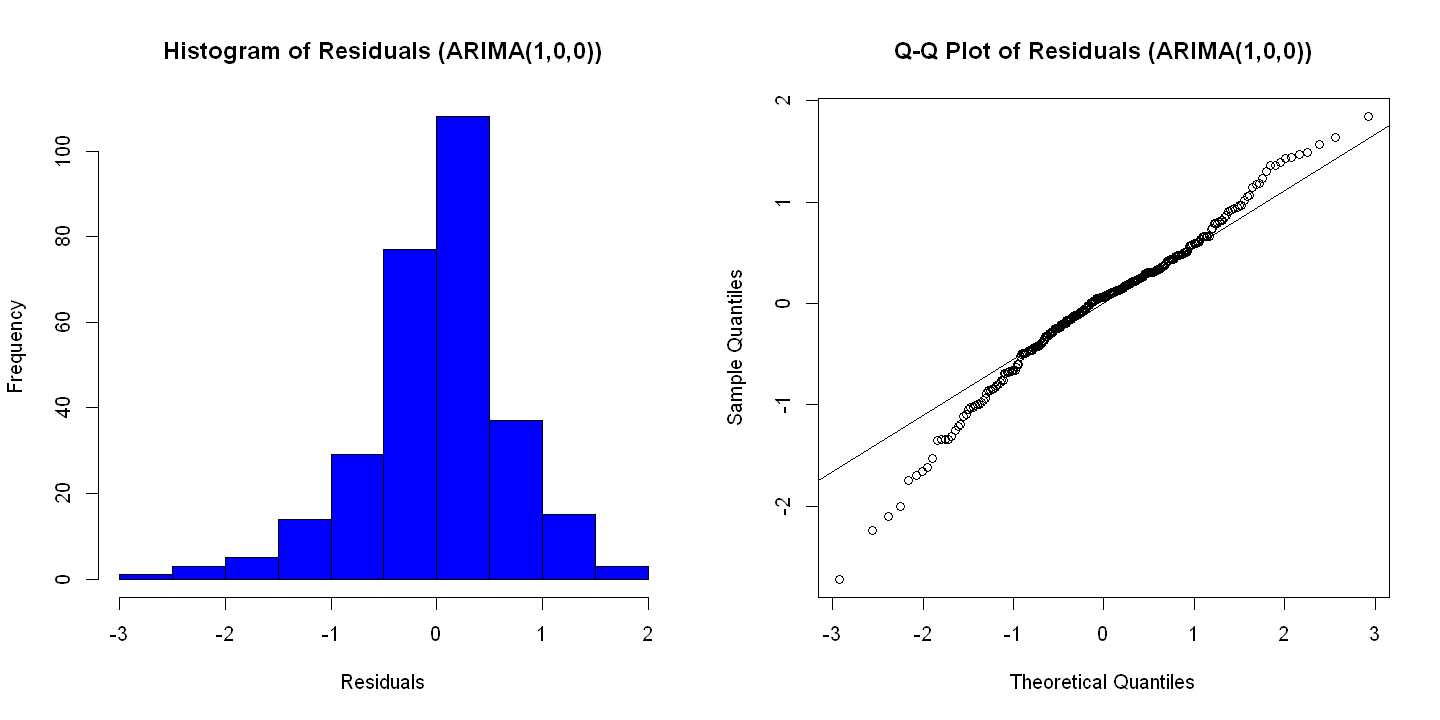

In [145]:
# Plot Histogram and Q-Q plot side by side
par(bg = "white", mfrow = c(1, 2))

# Histogram of residuals
hist(residuals_100, main = "Histogram of Residuals (ARIMA(1,0,0))", xlab = "Residuals", col = "blue")

# Q-Q plot for normality check
qqnorm(residuals_100, main = "Q-Q Plot of Residuals (ARIMA(1,0,0))")
qqline(residuals_100)

# Reset plotting layout
par(mfrow = c(1, 1))


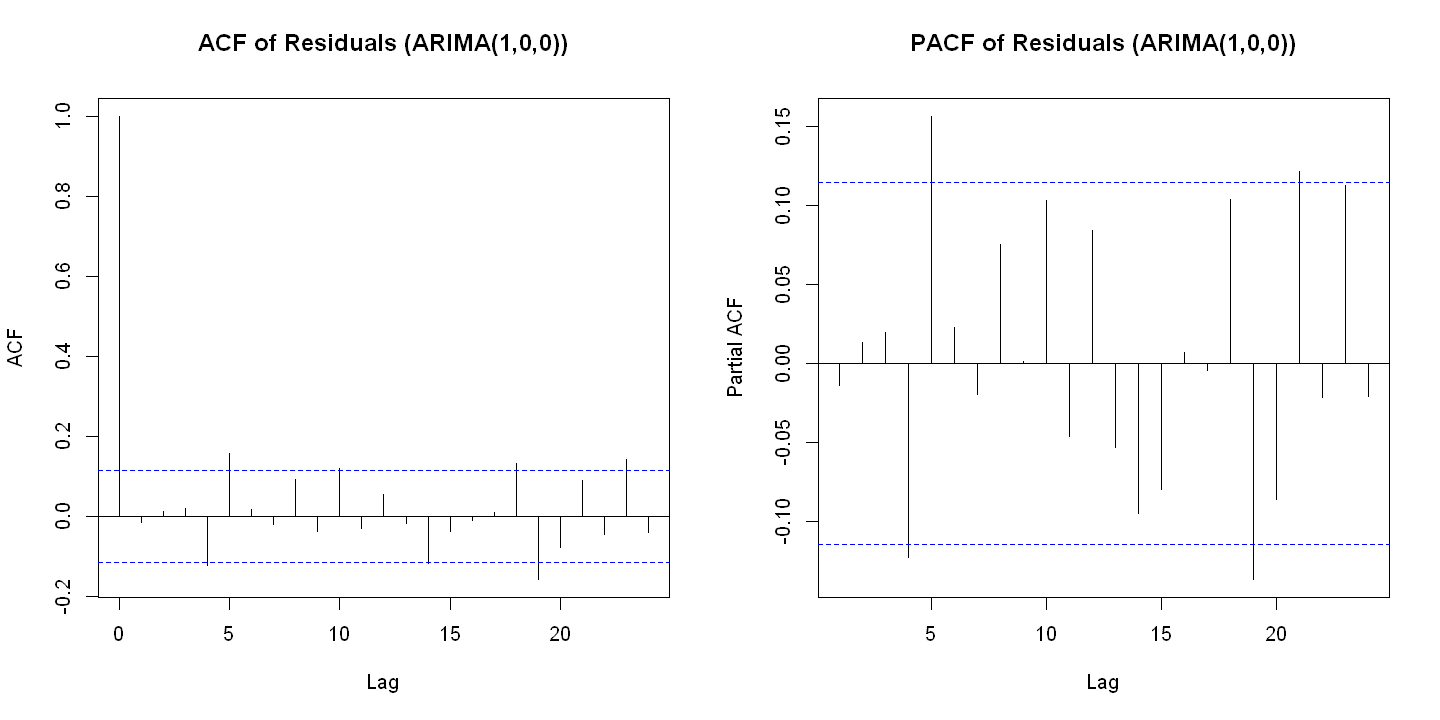

In [146]:
# Check for autocorrelation in residuals
par(bg = "white", mfrow = c(1, 2))
acf(residuals_100, main = "ACF of Residuals (ARIMA(1,0,0))")
pacf(residuals_100, main = "PACF of Residuals (ARIMA(1,0,0))")
par(mfrow = c(1, 1))


In [147]:
# Shapiro-Wilk test for normality
shapiro.test(residuals_100)



	Shapiro-Wilk normality test

data:  residuals_100
W = 0.97706, p-value = 0.0001245


In [148]:

runs_test_100 <- runs.test(residuals_100)
print(runs_test_100)


	Runs Test

data:  residuals_100
statistic = -1.8926, runs = 128, n1 = 145, n2 = 141, n = 286, p-value =
0.05841
alternative hypothesis: nonrandomness



### Model Validation: ARIMA(1,0,0)

**1. Residual Plots (Time Series & Histogram)**  

- The time series plot of residuals shows random fluctuations around zero, which is expected for a well-fitted model.  

- The histogram appears approximately normal, although slight deviations from normality are evident.

**2. ACF/PACF of Residuals**  

- The ACF plot indicates that most autocorrelations lie within the confidence limits, suggesting minimal serial correlation.  

- A few minor spikes maybe some remaining structure in the residuals.

**3. Ljung–Box Test**  

- The test yields a *p*-value of ~0.019, which is below the 0.05 threshold.

- This indicates the presence of some leftover autocorrelation, but it is comparable to ARIMA(1,0,1) and better than ARIMA(2,0,0).

**4. Runs Test**  

- The Runs test gives a *p*-value of ~0.058, which is above 0.05.

- This indicates that the signs of the residuals appear to be random.

**5. Shapiro–Wilk Test**  

- The Shapiro–Wilk test results in a *p*-value of 0.0001245, indicating that the residuals deviate from perfect normality.  

- However, the histogram and Q–Q plot do not reveal extreme departures from normality.

**Overall Assessment**  

- ARIMA(1,0,0) is the simplest model (with the fewest parameters) and has the best AIC/BIC among the alternatives.  

- While the Ljung–Box test shows borderline evidence of autocorrelation, the overall residual diagnostics are competitive, especially given the improved randomness indicated by the Runs test.  

- ARIMA(1,0,0) appears to be the **BEST** choice.


### Additional Validation with auto.arima()

To further validate our candidate models, we also used the `auto.arima()` function. This function automatically selects an optimal ARIMA model based on criteria such as AIC, AICc, and BIC. Its recommendation provides additional confidence in our choice by cross-checking the manual selection process.


In [149]:
auto_model = auto.arima(train$pm25_boxcox)
summary(auto_model)

Series: train$pm25_boxcox 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.6254  8.4561
s.e.  0.0455  0.1074

sigma^2 = 0.481:  log likelihood = -306.73
AIC=619.45   AICc=619.54   BIC=630.48

Training set error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.002346906 0.6911791 0.5157875 -0.7694885 6.376266 0.9486987
                    ACF1
Training set -0.01442029

## Forecasting 

Based on our analysis, ARIMA(1,0,0) is the strongest candidate. It was further validated by auto.arima() and shows the best residual behavior.


### **Forecasting ARIMA(1,0,0):** 


Forecast method: ARIMA(1,0,0) with non-zero mean

Model Information:
Series: train$pm25_boxcox 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.6254  8.4561
s.e.  0.0455  0.1074

sigma^2 = 0.481:  log likelihood = -306.73
AIC=619.45   AICc=619.54   BIC=630.48

Error measures:
                       ME      RMSE       MAE        MPE     MAPE      MASE
Training set -0.002346906 0.6911791 0.5157875 -0.7694885 6.376266 0.9486987
                    ACF1
Training set -0.01442029

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95     Hi 95
293       8.604973 7.716142 9.493804 7.245624  9.964323
294       8.549194 7.500860 9.597528 6.945905 10.152483
295       8.514311 7.409842 9.618779 6.825171 10.203450
296       8.492495 7.366833 9.618157 6.770943 10.214047
297       8.478852 7.345008 9.612695 6.744788 10.212916
298       8.470319 7.333292 9.607346 6.731386 10.209252
299       8.464983 7.326713 9.603253 6.724149 10.205817
300       8.461646 7.322890 9.6

    Point Forecast    Lo 80    Hi 80    Lo 95     Hi 95
293       8.604973 7.716142 9.493804 7.245624  9.964323
294       8.549194 7.500860 9.597528 6.945905 10.152483
295       8.514311 7.409842 9.618779 6.825171 10.203450
296       8.492495 7.366833 9.618157 6.770943 10.214047
297       8.478852 7.345008 9.612695 6.744788 10.212916
298       8.470319 7.333292 9.607346 6.731386 10.209252
299       8.464983 7.326713 9.603253 6.724149 10.205817
300       8.461646 7.322890 9.600402 6.720070 10.203223
301       8.459559 7.320614 9.598505 6.717692 10.201426
302       8.458254 7.319234 9.597274 6.716273 10.200235
303       8.457438 7.318389 9.596487 6.715413 10.199463
304       8.456927 7.317867 9.595988 6.714885 10.198970
305       8.456608 7.317543 9.595673 6.714559 10.198657
306       8.456408 7.317342 9.595475 6.714357 10.198460
307       8.456284 7.317216 9.595351 6.714231 10.198336
308       8.456205 7.317138 9.595273 6.714152 10.198259
309       8.456157 7.317089 9.595224 6.714103 10

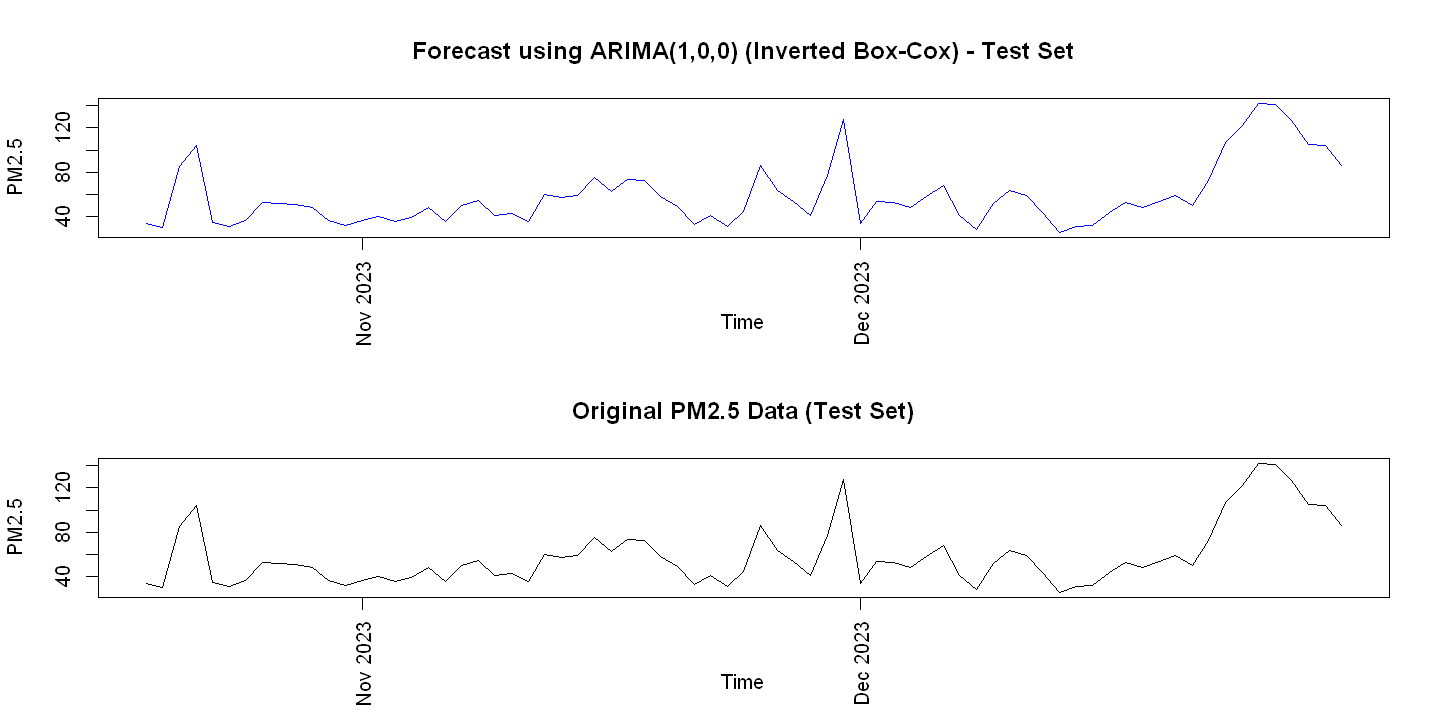

In [ ]:
# Set forecast horizon equal to test set length
forecast_horizon <- length(test$pm25)  

par(bg = "white", mfrow = c(2, 1))

# Generate forecasts on the Box-Cox transformed scale using ARIMA(1,0,0)
forecasts_100_test <- forecast(arima_model_100, h = forecast_horizon)
summary(forecasts_100_test)
print(forecasts_100_test)

# Invert the Box-Cox transformation for the forecasts
inverted_forecasts_100_test <- InvBoxCox(forecasts_100_test$mean, lambda_clean)
print(inverted_forecasts_100_test)

# Combine only the relevant forecasted part with the test data.
combined_data_test_100 <- c(test$pm25, inverted_forecasts_100_test)
combined_data_test_100 <- combined_data_test_100[1:length(test$pm25)]  # Trim extra forecasted days

# Create a Date index for the test set
start_date_test <- as.Date("2023-10-19")  #  match  test set start date
date_index_test <- seq.Date(from = start_date_test, by = "day", length.out = length(test$pm25))

# Plot the forecast (matching x-axis range with test set)
plot(date_index_test, combined_data_test_100, type = "l", xaxt = "n",
     main = "Forecast using ARIMA(1,0,0) (Inverted Box-Cox) - Test Set",
     ylab = "PM2.5", xlab = "Time", col = "blue", xlim = range(date_index_test))

# Create monthly tick marks
month_ticks_test <- seq.Date(from = as.Date(format(min(date_index_test), "%Y-%m-01")),
                             to   = as.Date(format(max(date_index_test), "%Y-%m-01")),
                             by   = "month")
axis.Date(side = 1, at = month_ticks_test, format = "%b %Y", las = 2)

# Plot the original test dataset with the same x-axis range
plot(date_index_test, test$pm25, type = "l", xaxt = "n",
     main = "Original PM2.5 Data (Test Set)", ylab = "PM2.5", xlab = "Time", xlim = range(date_index_test))
axis.Date(side = 1, at = month_ticks_test, format = "%b %Y", las = 2)

# Reset plotting layout to default
par(mfrow = c(1, 1))


In [151]:
accuracy_metrics <- accuracy(inverted_forecasts_100_test, test$pm25)
print(accuracy_metrics)

               ME     RMSE      MAE       MPE     MAPE
Test set 7.484546 28.51427 19.20222 -3.249954 30.89974


### **Forecast Evaluation**: ARIMA(1,0,0) with Non-Zero Mean

**1. Coefficients:**  

- The AR1 coefficient (0.6254) indicates moderate persistence, while the constant mean (8.4561) shows the long-term level the model reverts to. These remain unchanged and provide the backbone for the model's forecasts.

**2. Error Measures:**  

- **Training Set:**  

  - The in-sample performance was excellent with very low errors (RMSE ≈ 0.6912, MAPE ≈ 6.38%), suggesting that the model closely fits the training data.  

- **Test Set:**  

  - Out-of-sample, the errors increase significantly (RMSE ≈ 28.51427, MAPE ≈ 30.89974, and a bias/ME of ~7.48).

  - In the context of air quality forecasting, a MAPE around 30% falls within the typical range (20%–40%).

  - The positive bias (ME ≈ 7.48) indicates that, on average, forecasts are slightly overestimating PM2.5 levels by about 7.5 units, which in this context this bias is acceptable.

**3. Forecasting Accuracy & Decision on Model Acceptance:**  

- **Performance Context:**  

  - Although the training performance is stellar, the test set performance shows moderate forecasting accuracy.  

  - Given that typical air quality forecasts see MAPE values between 20% and 40%, a 30.9% MAPE is acceptable in many cases.

  - The RMSE should be considered relative to the average PM2.5 levels; if the average is around 50–60, an RMSE of 28.5 represents a moderate error that might be tolerable in volatile conditions but could be problematic for high-stakes decisions.  
   


## **Discussion**

### Summary  

We developed an ARIMA(1,0,0) model with a non-zero mean to forecast daily PM2.5 levels using Box–Cox transformed training data. While the model fit the training data extremely well, test set errors (MAPE ~30.9%, RMSE ~28.5, ME ~7.48) indicate moderate performance.

### Main Points  

- **Model Performance:**  

  - The model captures short-term dynamics effectively but converges to a constant mean over time, showing that its simple AR(1) structure may not fully capture complex behaviors.

  - Despite the excellent in-sample fit, the higher test set errors suggest the model doesn't generalize perfectly, possibly due to its inability to incorporate factors like weather or event-driven effects.

- **Data Limitations and Model Challenges:**  

  - The dataset was limited to only two features, which likely oversimplifies the true dynamics of PM2.5 influenced by external factors (e.g., weather, events), leaving no clear seasonal pattern to model.

  - Even after regression, the data does not fit a linear deterministic model well, necessitating the use of an ARIMA approach.

  - The Box–Cox transformation helped reduce in-sample error but may not have been sufficient to eliminate bias when forecasts are inverted.

  - Although the residual plots (QQ plot and histogram) looked fairly normal, the model strongly failed the Shapiro-Wilk test—this discrepancy was unexpected.


- **Decision Implications:**  

  - A ~30% error is acceptable for applications like public health advisories or policy formulation, ARIMA(1,0,0) stands as the best ARIMA candidate given the data constraints.



# **Conclusion**

In conclusion, ARIMA(1,0,0) demonstrates reasonable performance within the typical error ranges for air quality forecasts and offers a robust and simple approach for forecasting AQI data, delivering acceptable performance within the typical error ranges for air quality predictions.
